### Imports

In [20]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [21]:
# import, preprocess, and look over raw data

df = pd.read_csv("data/data_04_29_2025.csv")
df = df.dropna(subset=['DatasetID'])
df.replace("n/a", "", inplace=True)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df.rename(columns={'iEEG modality': 'iEEG Modality'}, inplace=True)
# df.set_index('DatasetID', inplace=True)
# Remove row with ds004215 in DatasetID
df = df[df['DatasetID'] != 'ds004215']

print(f'df shape: {df.shape}')
df.tail()

df shape: (292, 75)


/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_34296/1367333659.py:6: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_34296/1367333659.py:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,intern,DatasetID,Warning Message,Error Message,has_visualization,No papers linked - hard to find other data,"Multiple Papers linked, none match NEMAR",HED anotation,Participants,Age range,...,Date last update,Dataset DOI,References and links,Corresponding Manuascript provided in NEMAR,License,On Brainlife.org,Funding,FROM NEMAR: Ethics Approvals,TEAM FILL IN Ethics Approvals,IRB
288,liz,ds003352,please use the checkmaxfilter option before pr...,NaN,False,NaN,NaN,no,18.0,17-26,...,NaN,10.18112/openneuro.ds003352.v1.0.0,"appelhoff, s., sanderson, m., brooks, t., vlie...",not provided,cc0,True,NaN,NaN,NaN,NaN
289,liz,ds002791,the dataset indicates it contains data epochs ...,NaN,False,NaN,NaN,no,23.0,19-40,...,NaN,10.18112/openneuro.ds002791.v1.0.0,NaN,not provided,cc0,True,NaN,NaN,NaN,NaN
290,peter,ds005107,NaN,NaN,NaN,NaN,NaN,no,21.0,20-27,...,NaN,doi:10.18112/openneuro.ds005107.v1.0.3,NaN,not provided,cc0,False,NaN,NaN,NaN,NaN
291,peter,ds005274,NaN,NaN,NaN,NaN,NaN,no,22.0,20-26,...,NaN,doi:10.18112/openneuro.ds005274.v1.0.0,NaN,not provided,cc0,False,NaN,NaN,NaN,NaN
292,NaN,ds002761,"might not be able to process all subjects, (pu...",sub-313/meg/sub-313_task-mem_run-01_meg.ds and...,False,NaN,NaN,no,25.0,NaN,...,NaN,doi:10.18112/openneuro.ds002761.v1.1.2,https://github.com/gewimmer-neuro/memory-seque...,not provided,cc0,False,r.d. is supported by wellcome trust investigat...,NaN,the study was approved by the university colle...,yes


In [22]:
df_1 = df.copy()
corresponding_manuscript = df_1['Corresponding Manuascript provided in NEMAR']
percentage_provided = (corresponding_manuscript.str.lower().value_counts().get('provided', 0) / len(corresponding_manuscript)) * 100
print(f"Percentage of 'provided': {percentage_provided:.2f}%")

Percentage of 'provided': 57.53%


In [23]:
df_1 = df.copy()
multiple_institutions = df_1['Authors from multiple institutions in different state/country']
multiple_institutions = multiple_institutions.dropna()
percentage_y = (multiple_institutions.str.lower().value_counts().get('y', 0) / len(multiple_institutions)) * 100
print(f"Percentage of 'y': {percentage_y:.2f}%")

# percentage_provided = (multiple_institutions.str.lower().value_counts().get('provided', 0) / len(multiple_institutions)) * 100
# print(f"Percentage of 'provided': {percentage_provided:.2f}%")

Percentage of 'y': 44.33%


In [24]:
df_1 = df.copy()
multiple_institutions = df_1['TEAM FILL IN Ethics Approvals']
total = multiple_institutions.isna().sum() + multiple_institutions.str.lower().value_counts().get('n/a', 0) + multiple_institutions.str.lower().value_counts().get('', 0) + multiple_institutions.str.lower().value_counts().get('No', 0)
percentage_empty_or_na = (total / len(multiple_institutions)) * 100

print(f"Percentage of 'n/a' or NaN or empty: {100-percentage_empty_or_na:.2f}%")

Percentage of 'n/a' or NaN or empty: 65.07%


### Figure 1

Modality x Modality of experiment x type of experiment 

Network chart start w main modality (EEG, MEG, IEGG) and then continue to break up (like figure 4 in other paper)

In [11]:
LABEL_MAINMODALITY = 'Main Modality:'
LABEL_MODALITYOFEXP = 'Modality of Experiment:'
LABEL_TYPEOFEXP = 'Type of Experiment:'

df_fig1 = df[['EEG Modality', 'MEG Modality', 'iEEG Modality', 'FOR FIGURE - modality of exp', 'FOR FIGURE - type of exp']]

mainModality_types = ['EEG', 'MEG', 'iEEG']
modalityOfExp_types = df['FOR FIGURE - modality of exp'].unique()
typeOfExp_types = df['FOR FIGURE - type of exp'].unique()

# Create lists for the nodes and links
nodes = []
node_indices = {}
links = []
index = 0

# Add primary modalities to nodes
for mainModality in mainModality_types:
    mainModality = f"{LABEL_MAINMODALITY} {mainModality}"
    nodes.append(mainModality)
    node_indices[mainModality] = index
    index += 1

# Add additional modalities to nodes
for modalityOfExp in modalityOfExp_types:
    modalityOfExp = f"{LABEL_MODALITYOFEXP} {modalityOfExp}"
    nodes.append(modalityOfExp)
    node_indices[modalityOfExp] = index
    index += 1

# Add types of experiments to nodes
for typeOfExp in typeOfExp_types:
    typeOfExp = f"{LABEL_TYPEOFEXP} {typeOfExp}"
    nodes.append(typeOfExp)
    node_indices[typeOfExp] = index
    index += 1

# Create links between primary modalities and additional modalities
for mainModality in mainModality_types:
    mainModalityKey = f"{LABEL_MAINMODALITY} {mainModality}"
    for modalityOfExp in modalityOfExp_types:
        if pd.notna(modalityOfExp):
            modalityOfExpKey = f"{LABEL_MODALITYOFEXP} {modalityOfExp}"
            count = df_fig1[(df_fig1[f'{mainModality} Modality'] == 'x') & 
                            (df_fig1['FOR FIGURE - modality of exp'] == modalityOfExp)].shape[0]
            if count > 0:
                links.append({
                    'source': node_indices[mainModalityKey],
                    'target': node_indices[modalityOfExpKey],
                    'value': count
                })

# Create links between additional modalities and types of experiments
for modalityOfExp in modalityOfExp_types:
    if pd.notna(modalityOfExp):
        modalityOfExpKey = f"{LABEL_MODALITYOFEXP} {modalityOfExp}"
        for typeOfExp in typeOfExp_types:
            if pd.notna(typeOfExp):
                typeOfExpKey = f"{LABEL_TYPEOFEXP} {typeOfExp}"
                count = df_fig1[(df_fig1['FOR FIGURE - modality of exp'] == modalityOfExp) & 
                                (df_fig1['FOR FIGURE - type of exp'] == typeOfExp)].shape[0]
                if count > 0:
                    links.append({
                        'source': node_indices[modalityOfExpKey],
                        'target': node_indices[typeOfExpKey],
                        'value': count
                    })
    
# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=60,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Use the nodes list as labels
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
)])

fig.update_layout(
    font=dict(size=12),
    width=1200,  # Set the width to a smaller value to compress the figure horizontally
    height=800,  # Increase the height to make the diagram more vertically wide
)

# # Hide the node labels
# fig.update_traces(node=dict(label=["" for _ in nodes]))


fig.show()


In [12]:
# Calculate the percentage of datasets where EEG is used
eeg_count = df['EEG Modality'].notna().sum()
total_datasets = len(df)
percentage_eeg_used = (eeg_count / total_datasets) * 100

print(f"Percentage of datasets where EEG is used: {percentage_eeg_used:.2f}%")

Percentage of datasets where EEG is used: 75.34%


In [13]:
fig.write_image("results/v1.6/figure_2.svg", format='svg')
fig.write_image("results/v1.6/figure_2.png", format='png')

In [14]:
from collections import Counter, defaultdict

# Count the number of incoming connections and their total strength for each node
incoming_connections = Counter(link['target'] for link in links)
connection_strengths = defaultdict(int)
for link in links:
    connection_strengths[link['target']] += link['value']

# Print the number of incoming connections and their total strength for each node
for node, count in incoming_connections.items():
    strength = connection_strengths[node]
    print(f"Node: {nodes[node]}, Incoming Connections: {count}, Total Strength: {strength}")

Node: Modality of Experiment: visual, Incoming Connections: 3, Total Strength: 137
Node: Modality of Experiment: multisensory, Incoming Connections: 3, Total Strength: 45
Node: Modality of Experiment: resting state, Incoming Connections: 3, Total Strength: 24
Node: Modality of Experiment: tactile, Incoming Connections: 1, Total Strength: 3
Node: Modality of Experiment: auditory, Incoming Connections: 3, Total Strength: 50
Node: Modality of Experiment: motor, Incoming Connections: 2, Total Strength: 13
Node: Modality of Experiment: sleep, Incoming Connections: 2, Total Strength: 7
Node: Modality of Experiment: other, Incoming Connections: 2, Total Strength: 5
Node: Modality of Experiment: unknown, Incoming Connections: 2, Total Strength: 5
Node: Modality of Experiment: anasthesia, Incoming Connections: 1, Total Strength: 5
Node: Type of Experiment: motor, Incoming Connections: 3, Total Strength: 20
Node: Type of Experiment: perception, Incoming Connections: 6, Total Strength: 45
Node: T

### Figure 2

Figure 2 - Modality x Additional Modality
A network diagram or Sankey diagram displaying the connections between primary modality (e.g., EEG) and additional modalities (e.g., fMRI, behavioral). This can visually represent multi-modality studies and show how often additional methods were used


In [15]:
!pip3 install -U kaleido


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [16]:
from matplotlib.lines import Line2D

# Set the font to Arial for all text elements
plt.rcParams['font.family'] = 'Arial'

# Function to create and draw a single graph
def create_and_draw_graph(start_node, additional_modalities, df, title):
    G = nx.DiGraph()
    G.add_node(start_node)
    for modality in additional_modalities:
        G.add_node(modality)
        weight = df[(df[start_node] == 'x') & (df[modality] == 'x')].shape[0]
        if weight > 0:
            G.add_edge(start_node, modality, weight=weight)
    
    pos = nx.circular_layout(G)
    pos[start_node] = [0, 0]  # Place the start node in the center
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]

    print("weights before: " + str(weights))

    for i, weight in enumerate(weights):
        weights[i] = np.log1p(weight) * 4

    print("weights after: " + str(weights))

    plt.figure(figsize=(14, 12))  # Adjust figure size

    legend_weights = [2.772588722239781, 9.591581091193483, 12.178089750893692, 13.735948817940585, 14.854288266817232]
    # # Add a legend for edge thickness
    # legend_elements = [
    #     Line2D([0], [0], color=plt.cm.Blues(legend_weights[0] / max(legend_weights)), lw=legend_weights[0], label='# of datasets = 1'),
    #     Line2D([0], [0], color=plt.cm.Blues(legend_weights[1] / max(legend_weights)), lw=legend_weights[1], label='# of datasets = 10'),
    #     Line2D([0], [0], color=plt.cm.Blues(legend_weights[2] / max(legend_weights)), lw=legend_weights[2], label='# of datasets = 20'),
    #     Line2D([0], [0], color=plt.cm.Blues(legend_weights[3] / max(legend_weights)), lw=legend_weights[3], label='# of datasets = 30'),
    #     Line2D([0], [0], color=plt.cm.Blues(legend_weights[4] / max(legend_weights)), lw=legend_weights[4], label='# of datasets = 40'),
    # ]

    # Create a colorbar for the gradient legend
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=16))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0, shrink=0.5)  # Adjust colorbar position and size
    cbar.set_label('Number of Datasets', fontsize=18, rotation=270, labelpad=20, loc='center')  # Set colorbar title
    cbar.ax.tick_params(labelsize=14)  # Set tick label size
    cbar.set_ticks(legend_weights)  # Specify exact tick positions
    cbar.set_ticklabels(['1', '10', '20', '30', '40'])  # Set custom tick labels
    
    # plt.legend(handles=legend_elements, loc='upper left', fontsize=18, bbox_to_anchor=(1, 1))

    nx.draw(G, 
            pos, 
            with_labels=True, 
            node_size=14000, 
            node_color='skyblue', 
            font_size=25, 
            font_weight='bold', 
            edge_color=weights, 
            edge_cmap=plt.cm.Blues, 
            edge_vmin=0,  # Set the minimum value for the colormap
            edge_vmax=16,  # Set the maximum value for the colormap to 16
            width=[weight for weight in weights])  # Use weights for line thickness
    
    plt.title(title, fontsize=40, fontweight='bold', loc='center')  # Increase the font size of the title, make it bold, and center it
    plt.margins(0.1)  # Adjust the margins to ensure everything fits

In [17]:
# Function to create and draw a single graph
def create_and_draw_graph_percentages(start_node, additional_modalities, df, title):
    G = nx.DiGraph()
    G.add_node(start_node)
    for modality in additional_modalities:
        G.add_node(modality)

        if (start_node == 'EEG'):
            total_datasets = df['EEG'].notna().sum()
        elif (start_node == 'MEG'):
            total_datasets = df['MEG'].notna().sum()
        elif (start_node == 'iEEG'):
            total_datasets = df['iEEG'].notna().sum()
        
        weight = df[(df[start_node] == 'x') & (df[modality] == 'x')].shape[0]
        if weight > 0:
            percentage = (weight / total_datasets) * 100
            G.add_edge(start_node, modality, weight=percentage)
    
    pos = nx.circular_layout(G)
    pos[start_node] = [0, 0]  # Place the start node in the center
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]

    print("weights (percentages): " + str(weights))

    for i, weight in enumerate(weights):
        weights[i] = np.log1p(weight) * 4  # Adjust thickness based on percentage

    print("weights after scaling: " + str(weights))

    plt.figure(figsize=(14, 12))  # Adjust figure size

    legend_weights = [2.772588722239781, 9.591581091193483, 12.178089750893692, 13.735948817940585, 14.854288266817232, 15.727302530897303]

    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=16))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0, shrink=0.5)  # Adjust colorbar position and size
    cbar.set_label('Percentage of Datasets (%)', fontsize=18, rotation=270, labelpad=20, loc='center')  # Set colorbar title
    cbar.ax.tick_params(labelsize=14)  # Set tick label size
    cbar.set_ticks(legend_weights)  # Specify exact tick positions
    cbar.set_ticklabels(['1', '10', '20', '30', '40', '50'])  # Set custom tick labels

    nx.draw(G, 
            pos, 
            with_labels=True, 
            node_size=14000, 
            node_color='skyblue', 
            font_size=25, 
            font_weight='bold', 
            edge_color=weights, 
            edge_cmap=plt.cm.Blues, 
            edge_vmin=0,  # Set the minimum value for the colormap
            edge_vmax=18.46,  # Set the maximum value for the colormap to 18.46
            width=[weight for weight in weights])  # Use weights for line thickness
    
    plt.title(title, fontsize=40, fontweight='bold', loc='center')  # Increase the font size of the title, make it bold, and center it
    plt.margins(0.1)  # Adjust the margins to ensure everything fits


In [18]:
def conversion(var): 
    print(str(var) + ": " + str(np.log1p(var) * 4))

conversion(1)
conversion(10)
conversion(20)
conversion(30)
conversion(40)
conversion(50)

1: 2.772588722239781
10: 9.591581091193483
20: 12.178089750893692
30: 13.735948817940585
40: 14.854288266817232
50: 15.727302530897303


In [19]:
create_and_draw_graph('EEG', df_fig2_additionalModalities, df_fig2, 'EEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.1.svg', format='svg')
plt.savefig('results/v1.6/figure_3.1.png', format='png')

plt.show()


NameError: name 'df_fig2_additionalModalities' is not defined

weights before: [20, 3, 9, 1, 2]
weights after: [12.178089750893692, 5.545177444479562, 9.210340371976184, 2.772588722239781, 4.394449154672439]


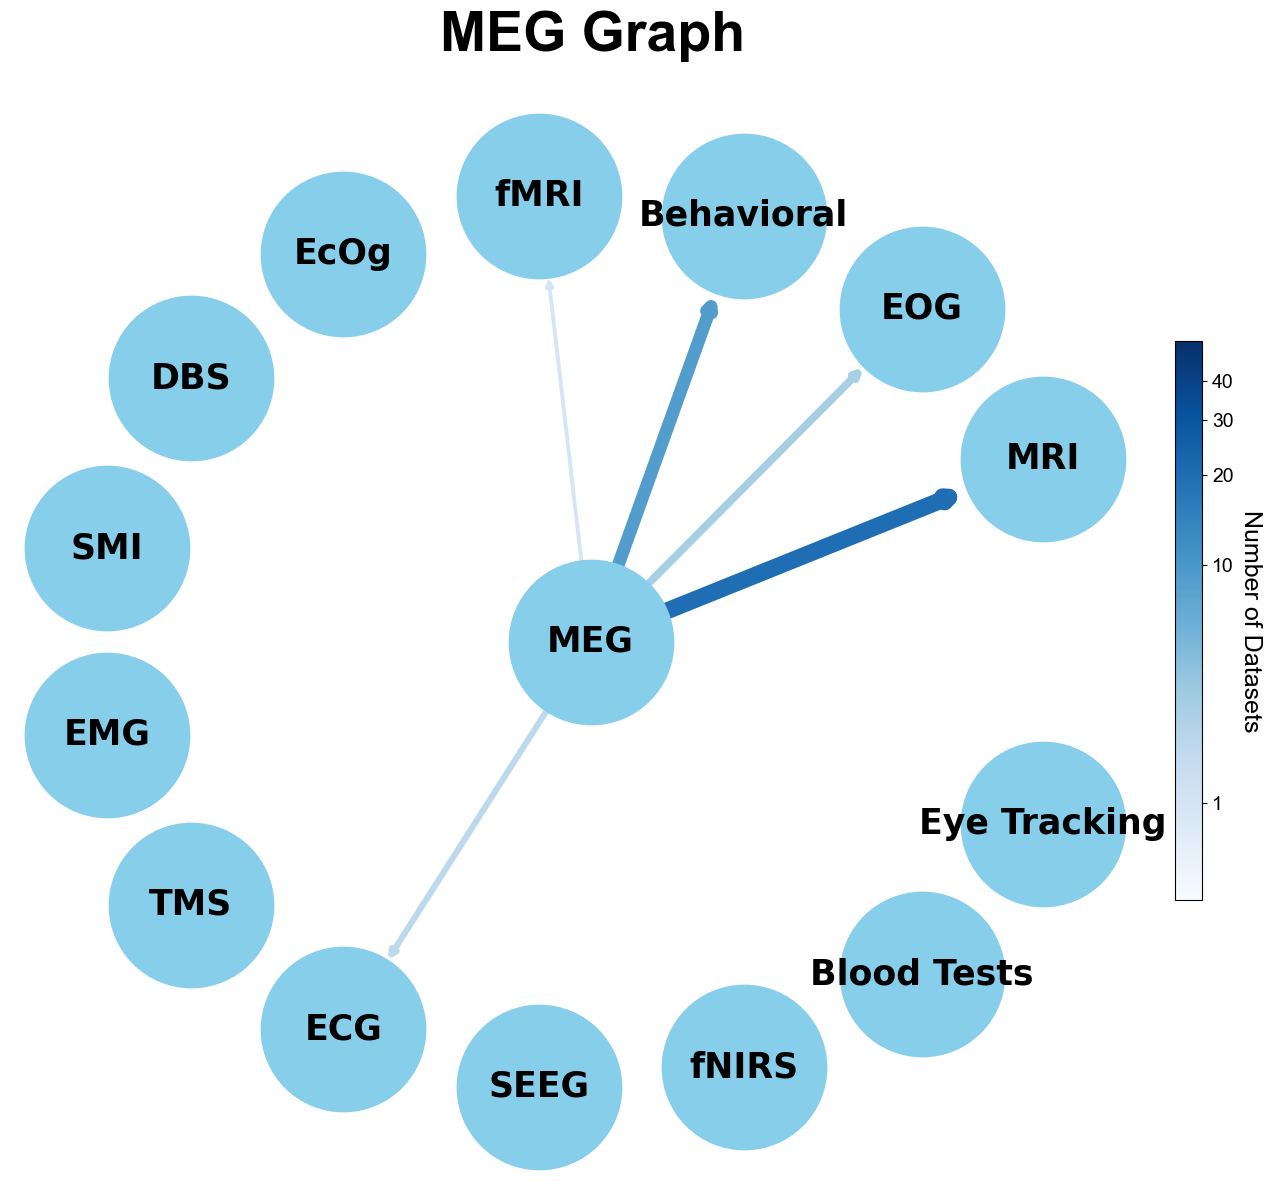

In [ ]:
# Draw the MEG graph
create_and_draw_graph('MEG', df_fig2_additionalModalities, df_fig2, 'MEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.2.svg', format='svg')
plt.savefig('results/v1.6/figure_3.2.png', format='png')

plt.show()

weights before: [12, 5, 1, 3, 3, 4]
weights after: [10.259797429846147, 7.16703787691222, 2.772588722239781, 5.545177444479562, 5.545177444479562, 6.437751649736401]


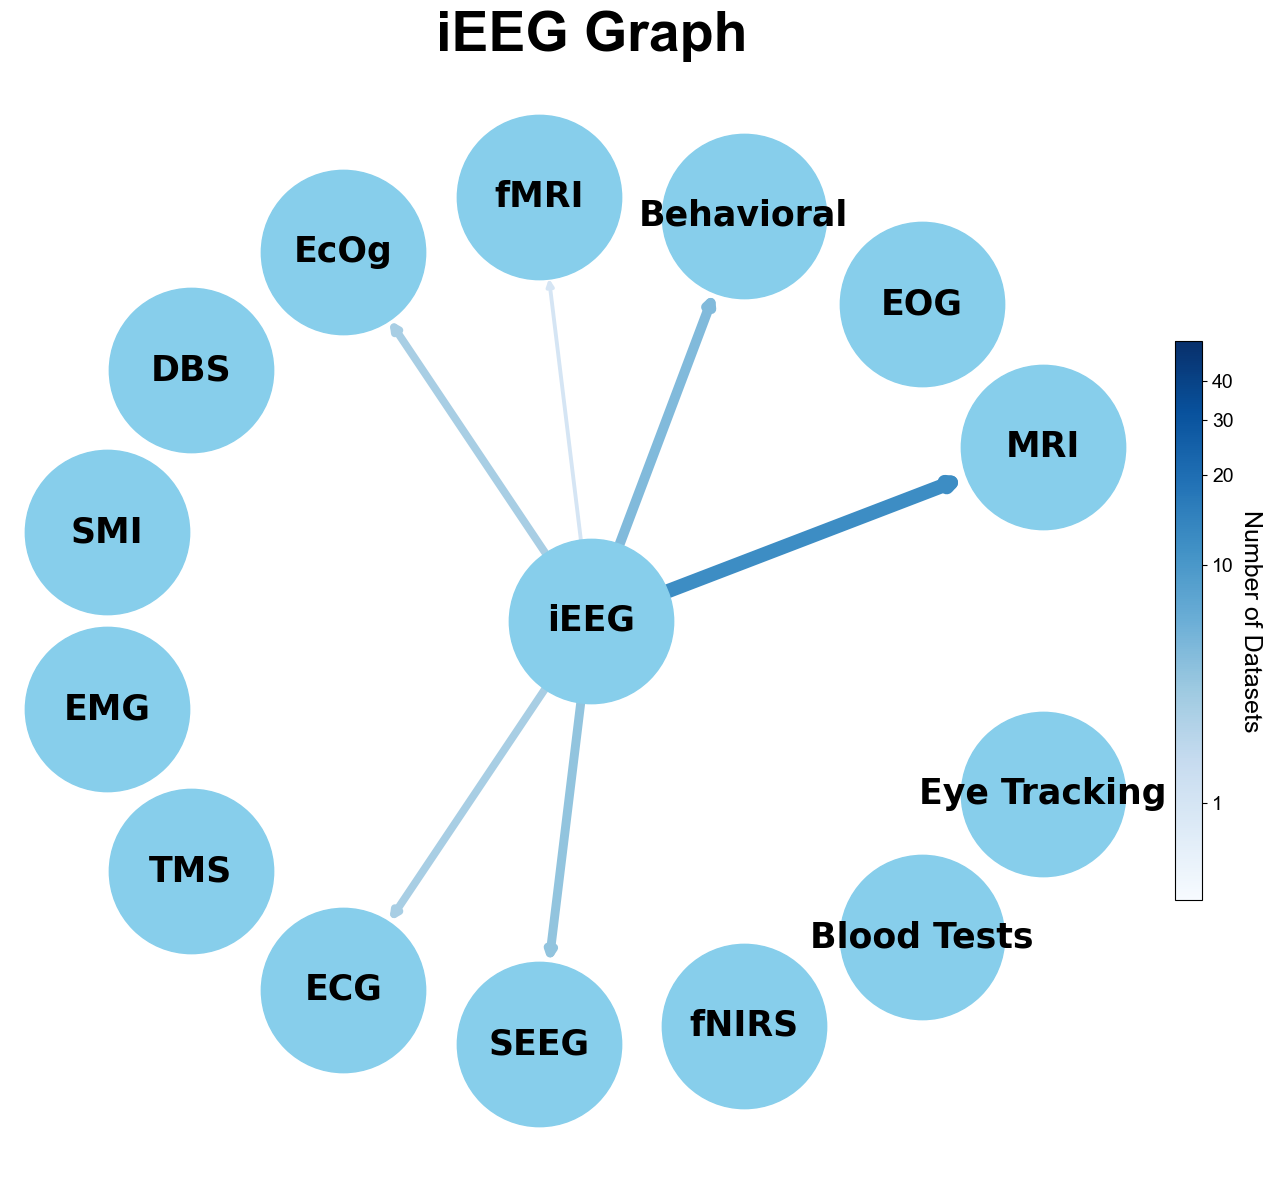

In [ ]:
# Draw the iEEG graph
create_and_draw_graph('iEEG', df_fig2_additionalModalities, df_fig2, 'iEEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.3.svg', format='svg')
plt.savefig('results/v1.6/figure_3.3.png', format='png')

plt.show()

weights (percentages): [9.090909090909092, 5.909090909090909, 22.272727272727273, 1.3636363636363635, 0.9090909090909091, 3.6363636363636362, 4.090909090909091, 1.3636363636363635, 3.1818181818181817, 0.45454545454545453, 0.9090909090909091, 2.272727272727273]
weights after scaling: [9.246539714055855, 7.731352269951842, 12.589128686724768, 3.440805060892446, 2.58650865970021, 6.135721439703821, 6.509825671747115, 3.440805060892446, 5.722984494762898, 1.4987737977656428, 2.58650865970021, 4.742494662630958]


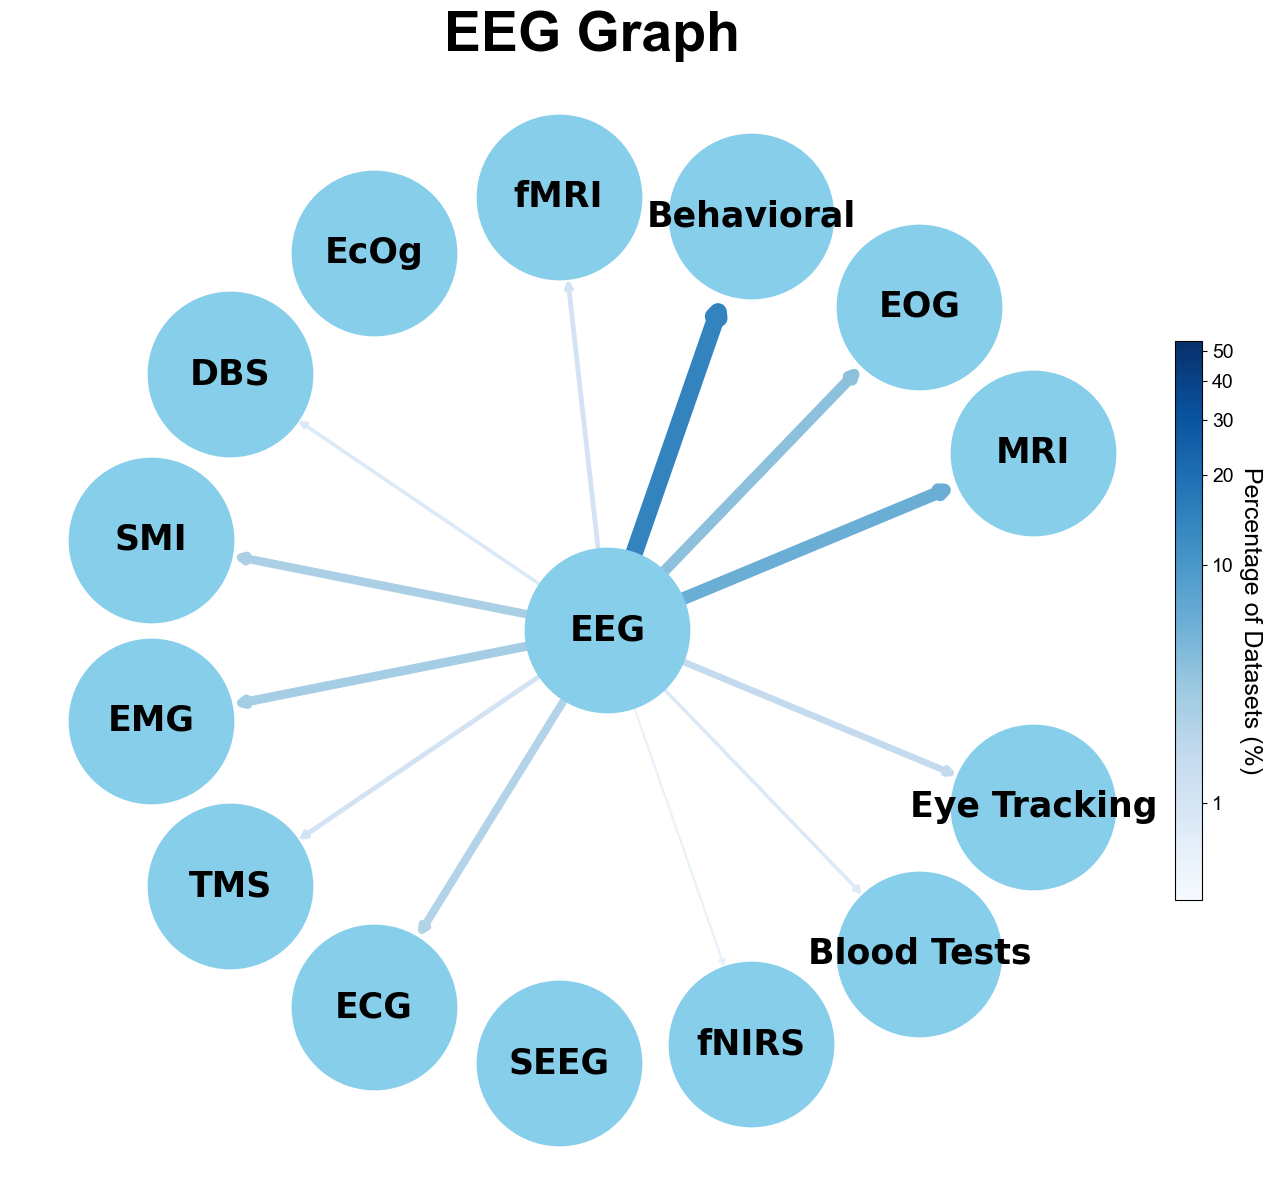

In [ ]:
create_and_draw_graph_percentages('EEG', df_fig2_additionalModalities, df_fig2, 'EEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.1_percentages.svg', format='svg')
plt.savefig('results/v1.6/figure_3.1_percentages.png', format='png')

plt.show()


weights (percentages): [50.0, 7.5, 22.5, 2.5, 5.0]
weights after scaling: [15.727302530897303, 8.560264653985083, 12.628001684600454, 5.011051873981472, 7.16703787691222]


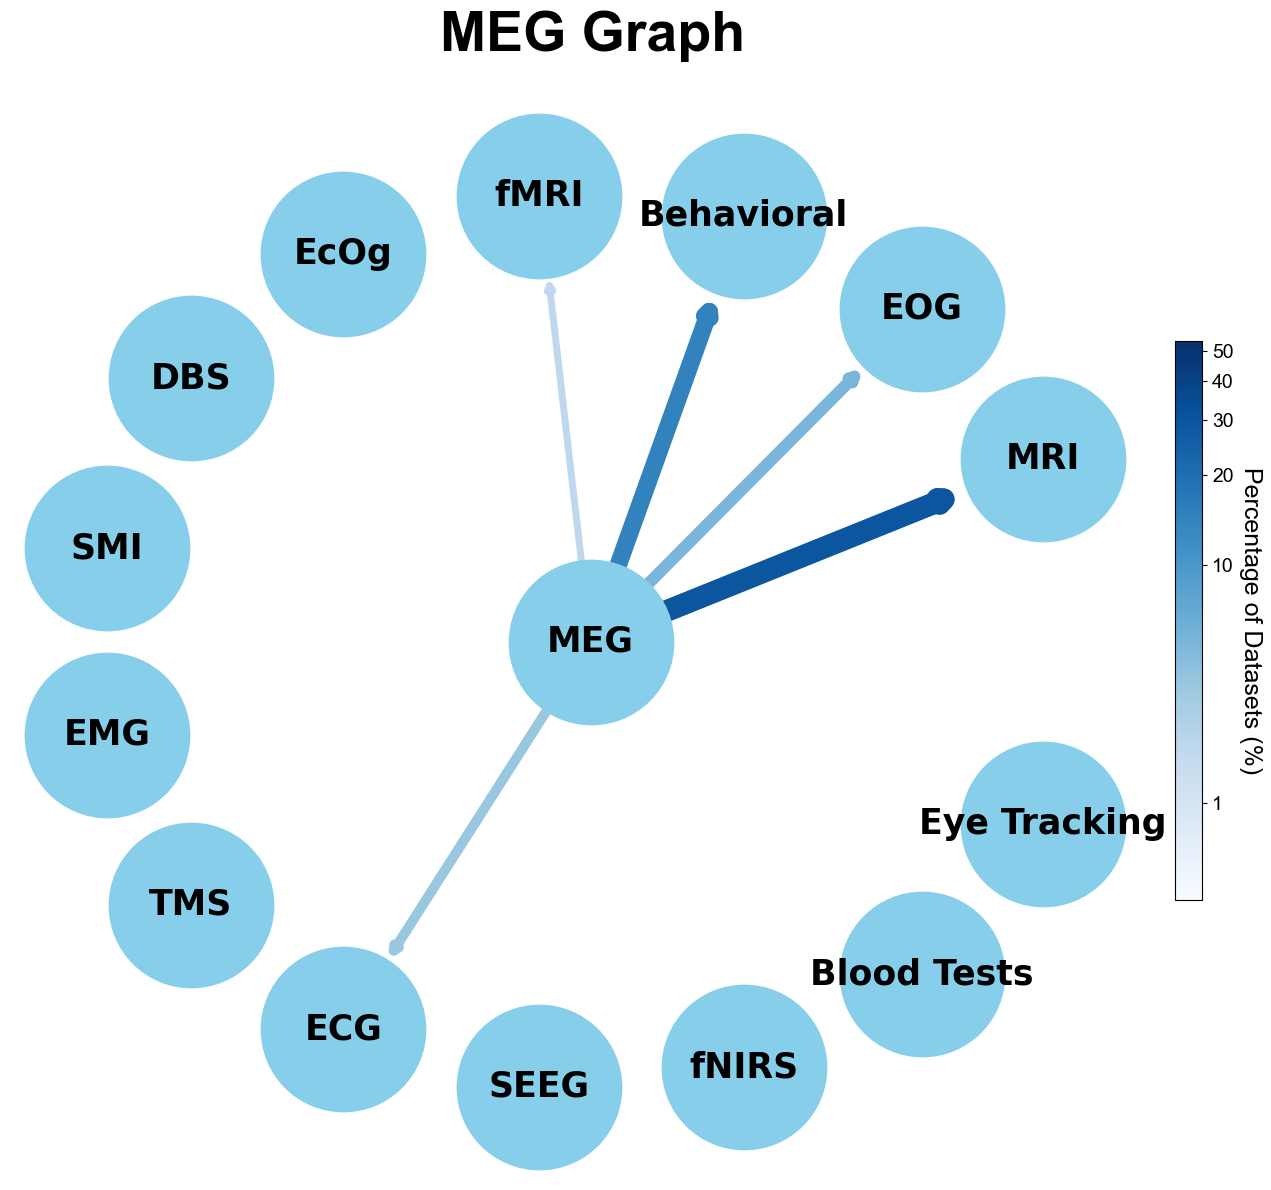

In [ ]:
create_and_draw_graph_percentages('MEG', df_fig2_additionalModalities, df_fig2, 'MEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.2_percentages.svg', format='svg')
plt.savefig('results/v1.6/figure_3.2_percentages.png', format='png')

plt.show()


weights (percentages): [35.294117647058826, 14.705882352941178, 2.941176470588235, 8.823529411764707, 8.823529411764707, 11.76470588235294]
weights after scaling: [14.366622719396688, 11.016141257376134, 5.485917101339, 9.139121873442157, 9.139121873442157, 10.186736037936974]


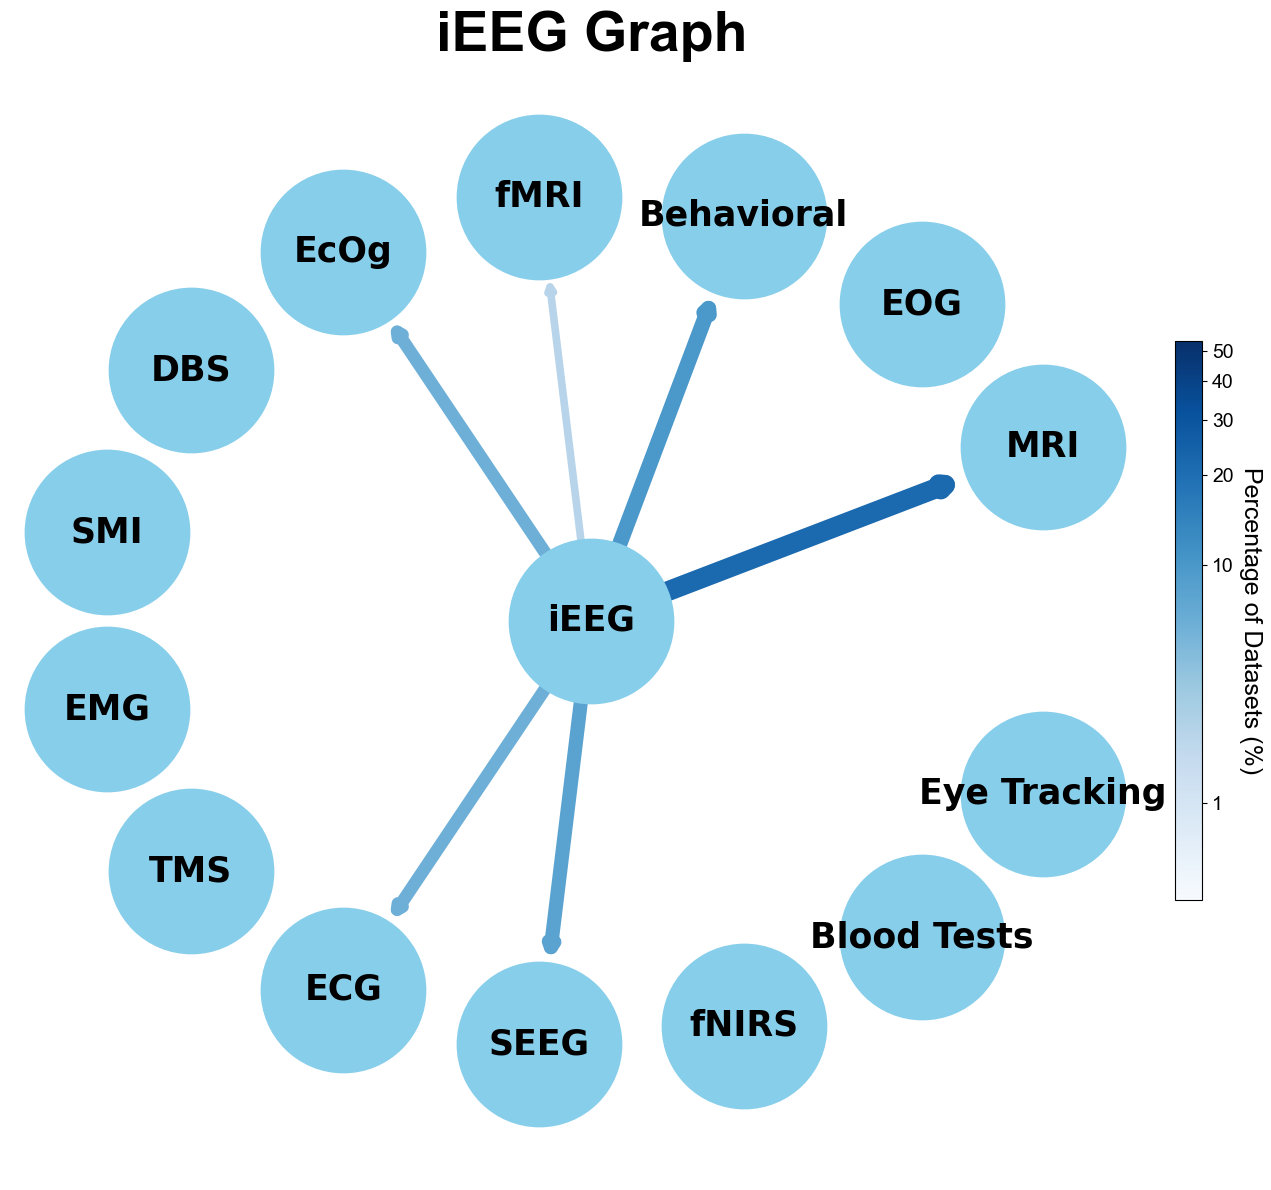

In [ ]:
create_and_draw_graph_percentages('iEEG', df_fig2_additionalModalities, df_fig2, 'iEEG Graph')

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.3_percentages.svg', format='svg')
plt.savefig('results/v1.6/figure_3.3_percentages.png', format='png')

plt.show()

In [ ]:
meg_mri_count = df_fig2[(df_fig2['iEEG'] == 'x') & (df_fig2['MRI'] == 'x')].shape[0]
print(f'Number of studies linking iEEG to MRI: {meg_mri_count}')

eeg_total_count = df_fig2[df_fig2['iEEG'] == 'x'].shape[0]
print(f'Total number of iEEG studies: {eeg_total_count}')

Number of studies linking iEEG to MRI: 12
Total number of iEEG studies: 34


In [ ]:
# Total number of EEG studies
total_eeg_studies = df['EEG Modality'].notna().sum()

# Number of EEG studies incorporating behavioral testing
eeg_behavioral_studies = df[(df['EEG Modality'].notna()) & (df['Has Behavioral'] == 'x')].shape[0]

print(f"Total EEG studies: {total_eeg_studies}")
print(f"EEG studies incorporating behavioral testing: {eeg_behavioral_studies}")

Total EEG studies: 220
EEG studies incorporating behavioral testing: 49


In [ ]:
# Total number of MEG studies
total_meg_studies = df['MEG Modality'].notna().sum()

# Number of MEG studies utilizing MRI
meg_mri_studies = df[(df['MEG Modality'].notna()) & (df['Has MRI'] == 'x')].shape[0]

print(f"Total MEG studies: {total_meg_studies}")
print(f"MEG studies utilizing MRI: {meg_mri_studies}")

Total MEG studies: 40
MEG studies utilizing MRI: 20


In [ ]:
# Total number of iEEG studies
total_ieeg_studies = df['iEEG Modality'].notna().sum()
print(f"Total iEEG studies: {total_ieeg_studies}")

# Number of iEEG studies utilizing MRI
ieeg_mri_studies = df[(df['iEEG Modality'].notna()) & (df['Has MRI'] == 'x')].shape[0]
print(f"iEEG studies utilizing MRI: {ieeg_mri_studies}")

Total iEEG studies: 34
iEEG studies utilizing MRI: 12


### Figure 3

Figure 3 - Author country x # of datasets x authors from multiple institutions

A world map showing the distribution of author countries. Use circles of varying sizes to represent the number of studies from each country, use heat map to show how many of those studies from each country were collaboration with another institution 


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import pandas as pd

'''
US has so many studies that it's hard to see the other countries on the map.
Removing US to see the other countries alone. 
Creating plot with international countries excluding US in two identical subplots.
'''

# create countries without US plot
countries = df['Author country']
countries = countries.astype(str)
countries = countries.str.strip().str.lower().str.replace('.', '')
replacements = {
    "usa": "united states",
    "uk": "united kingdom",
    "romani": "romania",
    'the netherlands': 'netherlands'
}
countries.replace(replacements, inplace=True)

countries_noUS = countries[countries != 'united states']
unique_countries_noUS, counts_noUS = np.unique(countries_noUS, return_counts=True)
country_counts_df = pd.DataFrame({
    'Country': unique_countries_noUS,
    'Count': counts_noUS
})

# Create US only plot
usa = df[['Author country', 'First author state']]
usa = usa.map(lambda x: x.strip().lower().replace('.', ''))
usa.replace({"usa": "united states"}, inplace=True)
usa = usa[usa['Author country'] == 'united states']

city_replacements = {
    'chicago': 'illinois',
    'pittsburgh': 'pennsylvania',
}
usa.replace(city_replacements, inplace=True)

states_unique, states_counts = np.unique(usa['First author state'], return_counts=True)
states_counts = states_counts.astype(int)

usa_counts_df = pd.DataFrame({
    'Country': states_unique,
    'Count': states_counts
})

state_abbrev = {
    'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA',
    'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
    'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA',
    'kansas': 'KS', 'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
    'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS', 'missouri': 'MO',
    'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new hampshire': 'NH', 'new jersey': 'NJ',
    'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC', 'north dakota': 'ND', 'ohio': 'OH',
    'oklahoma': 'OK', 'oregon': 'OR', 'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC',
    'south dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT',
    'virginia': 'VA', 'washington': 'WA', 'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY'
}
usa_counts_df['Country'] = usa_counts_df['Country'].map(state_abbrev).fillna(usa_counts_df['Country'])

# Create a subplot figure with two horizontal plots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "scattergeo"}, {"type": "scattergeo"}]],
    subplot_titles=("United States", "World (Excluding US)")
)

# Calculate a common sizeref for consistent circle sizing
max_count = max(usa_counts_df['Count'].max(), country_counts_df['Count'].max())
common_sizeref = 2.0 * max_count / (40**2)

# Create the first subplot for US states
fig.add_trace(
    go.Scattergeo(
        locations=usa_counts_df['Country'],
        locationmode='USA-states',
        marker=dict(
            size=usa_counts_df['Count'],
            color=usa_counts_df['Count'],
            colorscale='Viridis',
            sizemode='area',
            sizeref=common_sizeref,
            sizemin=3,
            colorbar=dict(
                title="Number of Studies",
                thickness=15,
                len=0.6,
                y=0.5,
                yanchor="middle",
                x=0.46,
                xanchor="right"
            )
        ),
        name='US States',
        showlegend=False
    ),
    row=1, col=1
)

# Create the second subplot for countries excluding US
fig.add_trace(
    go.Scattergeo(
        locations=country_counts_df['Country'],
        locationmode='country names',
        marker=dict(
            size=country_counts_df['Count'],
            color=country_counts_df['Count'],
            colorscale='Viridis',
            sizemode='area',
            sizeref=common_sizeref,
            sizemin=3,
            colorbar=dict(
                title="Number of Studies",
                thickness=15,
                len=0.6,
                y=0.5,
                yanchor="middle",
                x=1.0,
                xanchor="right"
            )
        ),
        name='Other Countries',
        showlegend=False
    ),
    row=1, col=2
)

# Update layout for both subplots
fig.update_geos(
    projection_type="albers usa",
    showcoastlines=False,
    showland=True,
    showsubunits=True,
    subunitcolor="gray",
    subunitwidth=0.5,
    row=1, col=1
)

fig.update_geos(
    projection_type="natural earth",
    showcoastlines=False,
    showland=True,
    showcountries=True,
    countrycolor="gray",
    countrywidth=0.5,
    row=1, col=2
)

# Update layout
fig.update_layout(
    title=dict(
        text="World Map with Circles Representing Number of Studies",
        font=dict(family="Arial", size=24),
        x=0.5,  # Center the title
        xanchor="center"
    ),
    font=dict(family="Arial"),
    height=600,
    width=1800,
    margin=dict(r=80)
)

# Update annotations (subplot titles) with larger font size
fig.update_layout(
    annotations=[
        dict(
            text="United States",
            font=dict(family="Arial", size=18),  # Increased font size
            showarrow=False,
            x=0.225,
            y=1.0,
            xanchor="center",
            yanchor="bottom"
        ),
        dict(
            text="World (Excluding US)",
            font=dict(family="Arial", size=18),  # Increased font size
            showarrow=False,
            x=0.8,
            y=1.0,
            xanchor="center",
            yanchor="bottom"
        )
    ]
)

# Remove duplicate colorbars by hiding one
fig.update_traces(
    marker=dict(
        showscale=True,  # Show colorbar only for the first trace
        colorbar=dict(
            x=0.45,  # Move the colorbar slightly to the right
            xanchor="left"
        )
    ),
    selector=dict(type='scattergeo', geo='geo')
)


fig.update_traces(
    marker=dict(
        showscale=False  # Hide colorbar for the second trace
    ),
    selector=dict(type='scattergeo', geo='geo2')
)

# Ensure axes are properly labeled
fig.update_layout(
    xaxis=dict(
        title=dict(
            text="Longitude",
            font=dict(family="Arial", size=12)
        )
    ),
    yaxis=dict(
        title=dict(
            text="Latitude",
            font=dict(family="Arial", size=12)
        )
    )
)

fig.show()

In [ ]:
# Save both figures as SVG and PNG
fig.write_image("results/v1.6/figure_1.svg", format='svg')
fig.write_image("results/v1.6/figure_1.png", format='png')

In [ ]:
# Calculate the percentage of studies from each country in descending order
country_percentages = countries.value_counts(normalize=True).sort_values(ascending=False) * 100

# Print the percentages
print(country_percentages)

Author country
united states     42.808219
united kingdom     8.219178
france             5.821918
germany            5.479452
australia          5.136986
switzerland        4.794521
china              4.109589
netherlands        2.397260
japan              2.054795
canada             1.712329
iran               1.712329
poland             1.369863
russia             1.369863
spain              1.369863
sweden             1.027397
denmark            1.027397
chile              0.684932
argentina          0.684932
india              0.684932
colombia           0.684932
hungary            0.684932
mexico             0.684932
greece             0.684932
italy              0.342466
england            0.342466
portugal           0.342466
norway             0.342466
austria            0.342466
ireland            0.342466
czechia            0.342466
south korea        0.342466
minnesota          0.342466
malaysia           0.342466
egypt              0.342466
romania            0.342466
singa

In [ ]:
# Calculate the percentage of studies from each state
usa_counts_df['Percentage'] = (usa_counts_df['Count'] / usa_counts_df['Count'].sum()) * 100

# Sort the DataFrame in descending order by the 'Percentage' column
usa_counts_df = usa_counts_df.sort_values(by='Percentage', ascending=False)

# Display the updated DataFrame
print(usa_counts_df)

   Country  Count  Percentage
6       MD     23        18.4
1       CA     19        15.2
12      NM     19        15.2
16      PA     11         8.8
13      NY     10         8.0
2       FL      6         4.8
4       IL      6         4.8
9       MN      4         3.2
3       GA      3         2.4
19      VA      3         2.4
8       MI      3         2.4
11      NV      3         2.4
0       AR      2         1.6
18      TX      2         1.6
10      MO      2         1.6
14      NC      2         1.6
7       MA      2         1.6
20      WA      2         1.6
15      OR      1         0.8
17      SD      1         0.8
5       IA      1         0.8


In [ ]:
'''
US has so many studies that it's hard to see the other countries on the map.
Removing US to see the other countries alone. 
Creating plot with international countries excluding US. 
'''

# create dataframe for number of studies from each country
countries = df['Author country']
countries = countries.astype(str)
countries = countries.str.strip().str.lower().str.replace('.', '')
replacements = {
    "usa": "united states",
    "uk": "united kingdom",
    "romani": "romania",
    'the netherlands': 'netherlands'
}
countries.replace(replacements, inplace=True)
# unique_countries, counts = np.unique(countries, return_counts=True)

# calculate df without US
countries_noUS = countries[countries != 'united states']
unique_countries_noUS, counts_noUS = np.unique(countries_noUS, return_counts=True)
country_counts_df = pd.DataFrame({
    'Country': unique_countries_noUS,
    'Count': counts_noUS
})

# Create a plotly scatter_geo plot
fig3_noUS = px.scatter_geo(country_counts_df, locations="Country", locationmode='country names',
                     size="Count", projection="natural earth",
                     title="World Map with Circles Representing Number of Studies",
                     color_continuous_scale="Viridis", labels={'Count': 'Number of Studies'})
fig3_noUS.update_layout(title={'text': "World Map with Circles Representing Number of Studies", 'x': 0.5})


fig3_noUS.show()


'''
Now, create a plot with only the US to see the distribution of studies within the US.
'''

usa = df[['Author country', 'First author state']]
usa = usa.map(lambda x: x.strip().lower().replace('.', ''))
usa.replace({"usa": "united states"}, inplace=True)
usa = usa[usa['Author country'] == 'united states']

city_replacements = {
    'chicago': 'illinois',
    'pittsburgh': 'pennsylvania',
}
usa.replace(city_replacements, inplace=True)

states_unique, states_counts = np.unique(usa['First author state'], return_counts=True)
states_counts = states_counts.astype(int)

usa_counts_df = pd.DataFrame({
    'Country': states_unique,
    'Count': states_counts
})
# Dictionary to convert state names to abbreviations
state_abbrev = {
    'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA',
    'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
    'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA',
    'kansas': 'KS', 'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
    'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS', 'missouri': 'MO',
    'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new hampshire': 'NH', 'new jersey': 'NJ',
    'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC', 'north dakota': 'ND', 'ohio': 'OH',
    'oklahoma': 'OK', 'oregon': 'OR', 'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC',
    'south dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT',
    'virginia': 'VA', 'washington': 'WA', 'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY'
}
# Convert state names to abbreviations
usa_counts_df['Country'] = usa_counts_df['Country'].map(state_abbrev).fillna(usa_counts_df['Country'])

fig3_us = px.scatter_geo(usa_counts_df, locations="Country", locationmode='USA-states',
                     size="Count", projection="albers usa",
                     title="US Map with Circles Representing Number of Studies",
                     color_continuous_scale="Viridis")
fig3_us.show()

### Figure 4

Figure 4 - Published date x number of datasets x modality

A line graph showing the number of publications over time, segmented by modality

denote that all of the data is combination - like mri is eeg-mri

denote this is over evolution of nemar/openneuro, thats how old database is

take top 3 eeg/meg/ieeg on one plot, and then the other modalities on another plot

In [ ]:
df_fig4 = df[['EEG Modality', 
              'MEG Modality', 
              'iEEG Modality',
              'Has MRI',
              'Has EOG',
              'Has Behavioral',
              'Has fMRi',
              'Has EcOg',
              'Has DBS',
              'Has SMI',
              'Has EMG',
              'Has TMS',
              'Has ECG',
              'Has SEEG',
              'Has fNIRS',
              'Has Blood Tests',
              'Eye tracking',
              'Other (put in name)',
              'Published date']]

df_fig4.rename(columns={
    'EEG Modality': 'EEG',
    'MEG Modality': 'MEG',
    'iEEG Modality': 'iEEG',
    'Has MRI': 'MRI',
    'Has EOG': 'EOG',
    'Has Behavioral': 'Behavioral',
    'Has fMRi': 'fMRI',
    'Has EcOg': 'EcOg',
    'Has DBS': 'DBS',
    'Has SMI': 'SMI',
    'Has EMG': 'EMG',
    'Has TMS': 'TMS',
    'Has ECG': 'ECG',
    'Has SEEG': 'SEEG',
    'Has fNIRS': 'fNIRS',
    'Has Blood Tests': 'Blood Tests',
    'Eye tracking': 'Eye Tracking',
    'Other (put in name)': 'Other'
}, inplace=True)

df_fig4_primaryModalities = df_fig4[['EEG', 'MEG', 'iEEG', 'Published date']]
df_fig4_secondaryModalities = df_fig4[['MRI', 
                                       'EOG', 
                                       'Behavioral', 
                                       'fMRI', 
                                       'EcOg', 
                                       'DBS', 
                                       'SMI', 
                                       'EMG', 
                                       'TMS', 
                                       'ECG', 
                                       'SEEG', 
                                       'fNIRS', 
                                       'Blood Tests', 
                                       'Eye Tracking', 
                                       'Other', 
                                       'Published date']]


# primary modality graph generation

# Initialize the dictionary with empty dataframes
dfs_by_modalities = {col: pd.DataFrame(columns=df_fig4.columns) for col in df_fig4_primaryModalities.columns if col != 'Published date'}
# Populate the dataframes
for index, row in df_fig4_primaryModalities.iterrows():
    for col in dfs_by_modalities.keys():
        if pd.notna(row[col]):
            dfs_by_modalities[col].loc[len(dfs_by_modalities[col])] = row
# Convert 'Published date' to datetime for sorting
for modality, modality_df in dfs_by_modalities.items():
    modality_df['Published date'] = pd.to_datetime(modality_df['Published date'])
    dfs_by_modalities[modality] = modality_df.sort_values(by='Published date')
    # Create a cumulative count of publications over time for each modality
    dfs_by_modalities[modality]['Cumulative Publications'] = range(1, len(modality_df) + 1)
# Create a plotly line graph for all modalities
df_fig4_primaryModalities = go.Figure()
for modality, modality_df in dfs_by_modalities.items():
    df_fig4_primaryModalities.add_trace(go.Scatter(
        x=modality_df['Published date'],
        y=modality_df['Cumulative Publications'],
        mode='lines',
        name=modality
    ))
df_fig4_primaryModalities.update_layout(
    title={
        'text': 'Dataset Publications Over Time for Primary Modalities',
        'x': 0.5,  # Center the title
        'xanchor': 'center'
    },
    xaxis_title='Published Date',
    yaxis_title='Cumulative Number of Publications'
)

df_fig4_primaryModalities.update_layout(
    title={
        'text': 'Dataset Publications Over Time for Primary Modalities',
        'x': 0.5,  # Center the title
        'xanchor': 'center',
        'font': {'family': 'Arial', 'size': 36}  # Increase font size
    },
    xaxis_title={
        'text': 'Published Date',
        'font': {'family': 'Arial', 'size': 24}  # Increase font size
    },
    yaxis_title={
        'text': 'Number of Publications',
        'font': {'family': 'Arial', 'size': 24}  # Increase font size
    },
    font={'family': 'Arial', 'size': 18},  # Set the default font size for the entire figure
    legend={
        'font': {'family': 'Arial', 'size': 24}  # Increase font size
    },
    width=1400,  # Increase the width of the figure
    height=800   # Increase the height of the figure
)

# # secondary modality graph generation

# # Initialize the dictionary with empty dataframes
# dfs_by_modalities = {col: pd.DataFrame(columns=df_fig4.columns) for col in df_fig4_secondaryModalities.columns if col != 'Published date'}
# # Populate the dataframes
# for index, row in df_fig4_secondaryModalities.iterrows():
#     for col in dfs_by_modalities.keys():
#         if pd.notna(row[col]):
#             dfs_by_modalities[col].loc[len(dfs_by_modalities[col])] = row
# # Convert 'Published date' to datetime for sorting
# for modality, modality_df in dfs_by_modalities.items():
#     modality_df['Published date'] = pd.to_datetime(modality_df['Published date'])
#     dfs_by_modalities[modality] = modality_df.sort_values(by='Published date')
#     # Create a cumulative count of publications over time for each modality
#     dfs_by_modalities[modality]['Cumulative Publications'] = range(1, len(modality_df) + 1)
# # Create a plotly line graph for all modalities
# df_fig4_secondaryModalities = go.Figure()
# for modality, modality_df in dfs_by_modalities.items():
#     df_fig4_secondaryModalities.add_trace(go.Scatter(
#         x=modality_df['Published date'],
#         y=modality_df['Cumulative Publications'],
#         mode='lines',
#         name=modality
#     ))
# df_fig4_secondaryModalities.update_layout(
#     title='Cumulative Publications Over Time for Additional Modalities',
#     xaxis_title='Published Date',
#     yaxis_title='Cumulative Number of Publications'
# )

df_fig4_primaryModalities.write_image("results/v1.6/figure_4.svg")
df_fig4_primaryModalities.write_image("results/v1.6/figure_4.png")


df_fig4_primaryModalities.show()
# df_fig4_secondaryModalities.show()

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/4249542202.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Ensure the 'Published date' column is in datetime format
df['Published date'] = pd.to_datetime(df['Published date'], errors='coerce')

# Filter for rows where 'EEG Modality' is not null
eeg_datasets = df[df['EEG Modality'].notna()]

# Group by year and count the number of datasets
eeg_datasets_per_year = eeg_datasets['Published date'].dt.year.value_counts().sort_index()

# Display the result
print(eeg_datasets_per_year)

Published date
2019    11
2020    24
2021    45
2022    47
2023    62
2024    31
Name: count, dtype: int64


In [ ]:
# Ensure the 'Published date' column is in datetime format
df['Published date'] = pd.to_datetime(df['Published date'], errors='coerce')

# Filter EEG datasets
eeg_datasets = df[df['EEG Modality'].notna()]

eeg_datasets_before_2020 = eeg_datasets[eeg_datasets['Published date'] <= '2020-01-01']
eeg_datasets_before_2024 = eeg_datasets[eeg_datasets['Published date'] <= '2024-01-01']
eeg_datasets

# Count the number of EEG datasets
number_of_eeg_datasets_2020 = len(eeg_datasets_before_2020)
number_of_eeg_datasets_2024 = len(eeg_datasets_before_2024)

print(f"Number of EEG datasets at the start of 2020: {number_of_eeg_datasets_2020}")
print(f"Number of EEG datasets at the start of 2024: {number_of_eeg_datasets_2024}")

Number of EEG datasets at the start of 2020: 11
Number of EEG datasets at the start of 2024: 220


In [ ]:
# Find the most recent 'Published date' in the main dataframe
most_recent_date = df['Published date'].max()
print(f"The most recent dataset was added on: {most_recent_date}")

The most recent dataset was added on: 2024-07-15 19:31:33


### Figure 5.1

Figure 5 - EEG channel histogram (see which are most common)

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/131949960.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/131949960.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



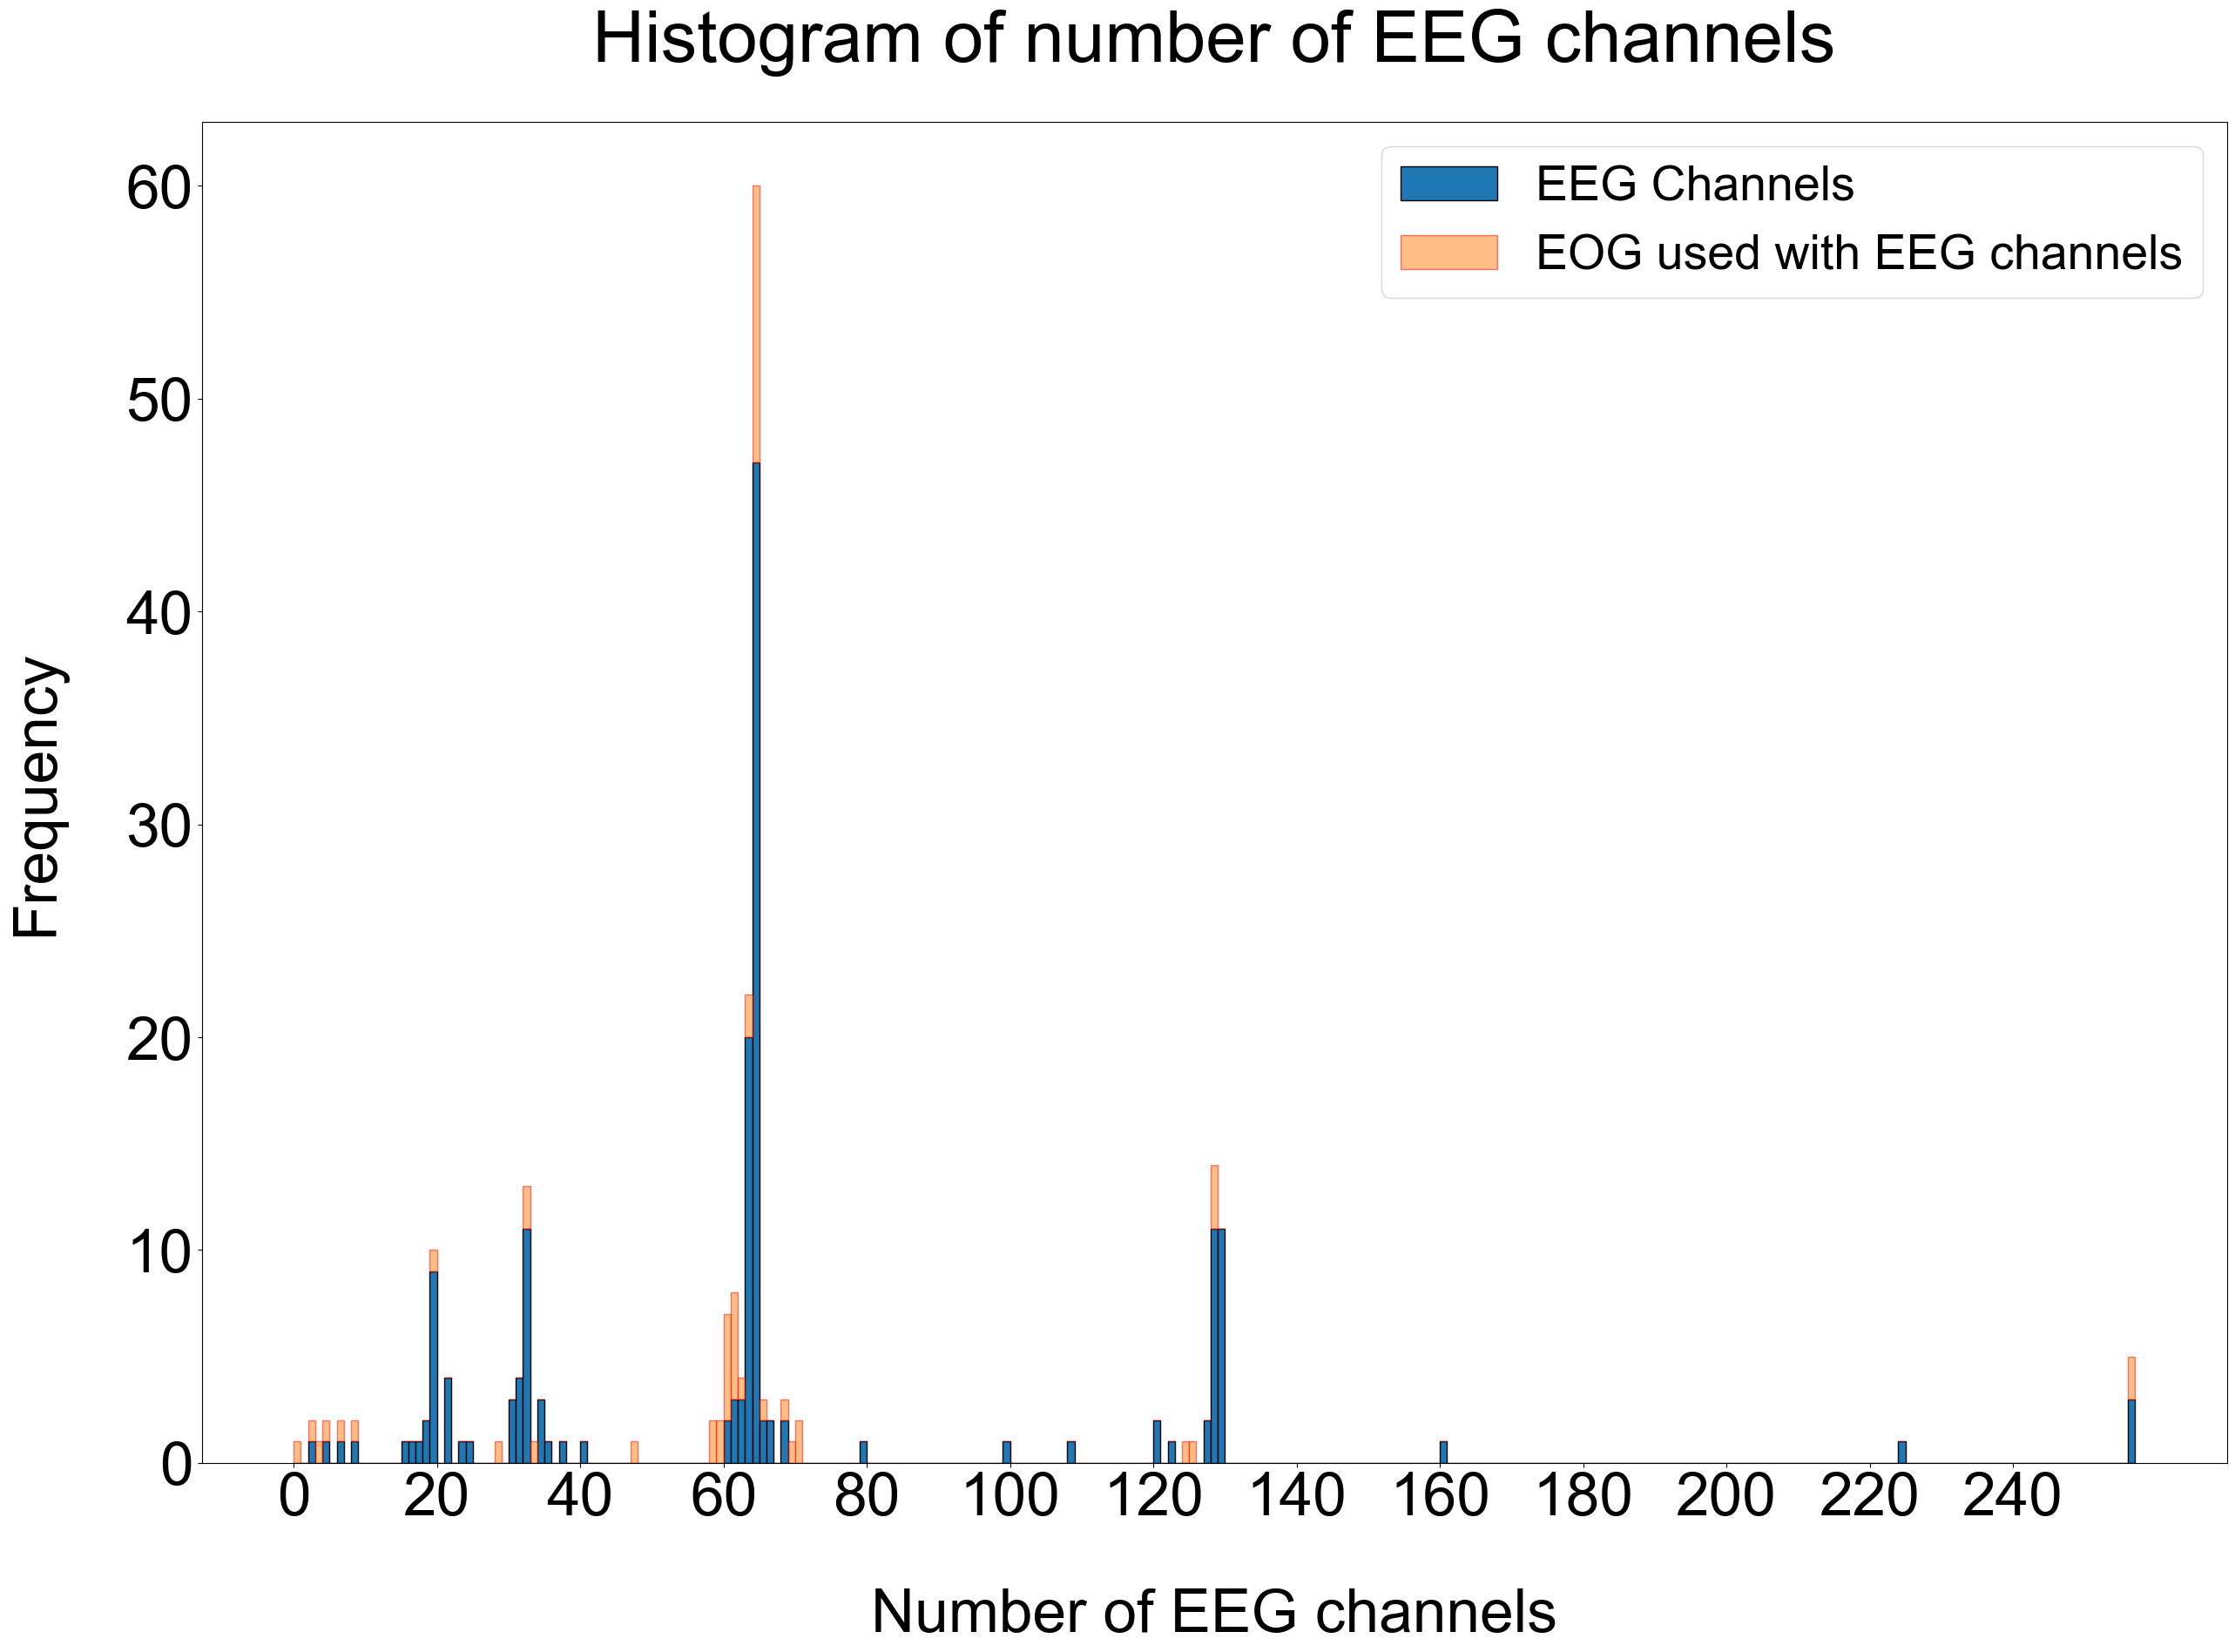

In [ ]:
df_eeg_channels = df['EEG channels']
df_eeg_channels.replace("n/a", "", inplace=True)
df_eeg_channels.dropna()

# Convert the EEG channels to numeric, forcing errors to NaN
df_eeg_channels = pd.to_numeric(df_eeg_channels, errors='coerce')

# Drop NaN values
df_eeg_channels.dropna(inplace=True)

df_eog_channels = df[['EEG channels', 'EOG channels']]
df_eog_channels.dropna(inplace=True)
df_eog_channels.drop(columns=['EOG channels'], inplace=True)
df_eog_channels = df_eog_channels.apply(pd.to_numeric, errors='coerce')
df_eog_channels.dropna(inplace=True)

# Define the number of bins for the histogram
BIN_COUNT_EEG = int(df_eeg_channels.max())

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Create the histogram without EOG data
fig_eeg, ax_eeg = plt.subplots(figsize=(30, 20))  # Increase the width of the figure
hist_eeg, bin_edges = np.histogram(df_eeg_channels, bins=BIN_COUNT_EEG)

# Plot the EOG data on the same histogram, but at the top of each bar/bin
hist_eog, _ = np.histogram(df_eog_channels, bins=bin_edges)
hist_eeg -= hist_eog
hist_eeg[-1] -= 2

# Plot the histogram
ax_eeg.bar(bin_edges[:-1], hist_eeg, width=np.diff(bin_edges), label='EEG Channels', edgecolor="black", align="edge")
ax_eeg.bar(bin_edges[:-1], hist_eog, width=np.diff(bin_edges), edgecolor="red", align="edge", alpha=0.5, label='EOG used with EEG channels', bottom=hist_eeg)
ax_eeg.set_xlabel('Number of EEG channels', fontsize=50, labelpad=50, fontfamily='Arial')  # Added labelpad for spacing
ax_eeg.set_ylabel('Frequency', fontsize=50, labelpad=50, fontfamily='Arial')  # Added labelpad for spacing
ax_eeg.set_title('Histogram of number of EEG channels', fontsize=60, pad=50, fontfamily='Arial')  # Added pad for spacing
ax_eeg.tick_params(axis='both', which='major', labelsize=50)

# Set x-axis ticks to be marked every 10
ax_eeg.set_xticks(np.arange(0, max(bin_edges), 20))

ax_eeg.legend(fontsize='40')

# Save the plot as a PNG and an SVG
fig_eeg.savefig('results/v1.6/figure_5.1.png', format='png')
fig_eeg.savefig('results/v1.6/figure_5.1.svg', format='svg')

plt.show()

### Figure 5.2

Figure 5 - MEG channel histogram w/ MRI data

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/3069420697.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_10902/3069420697.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



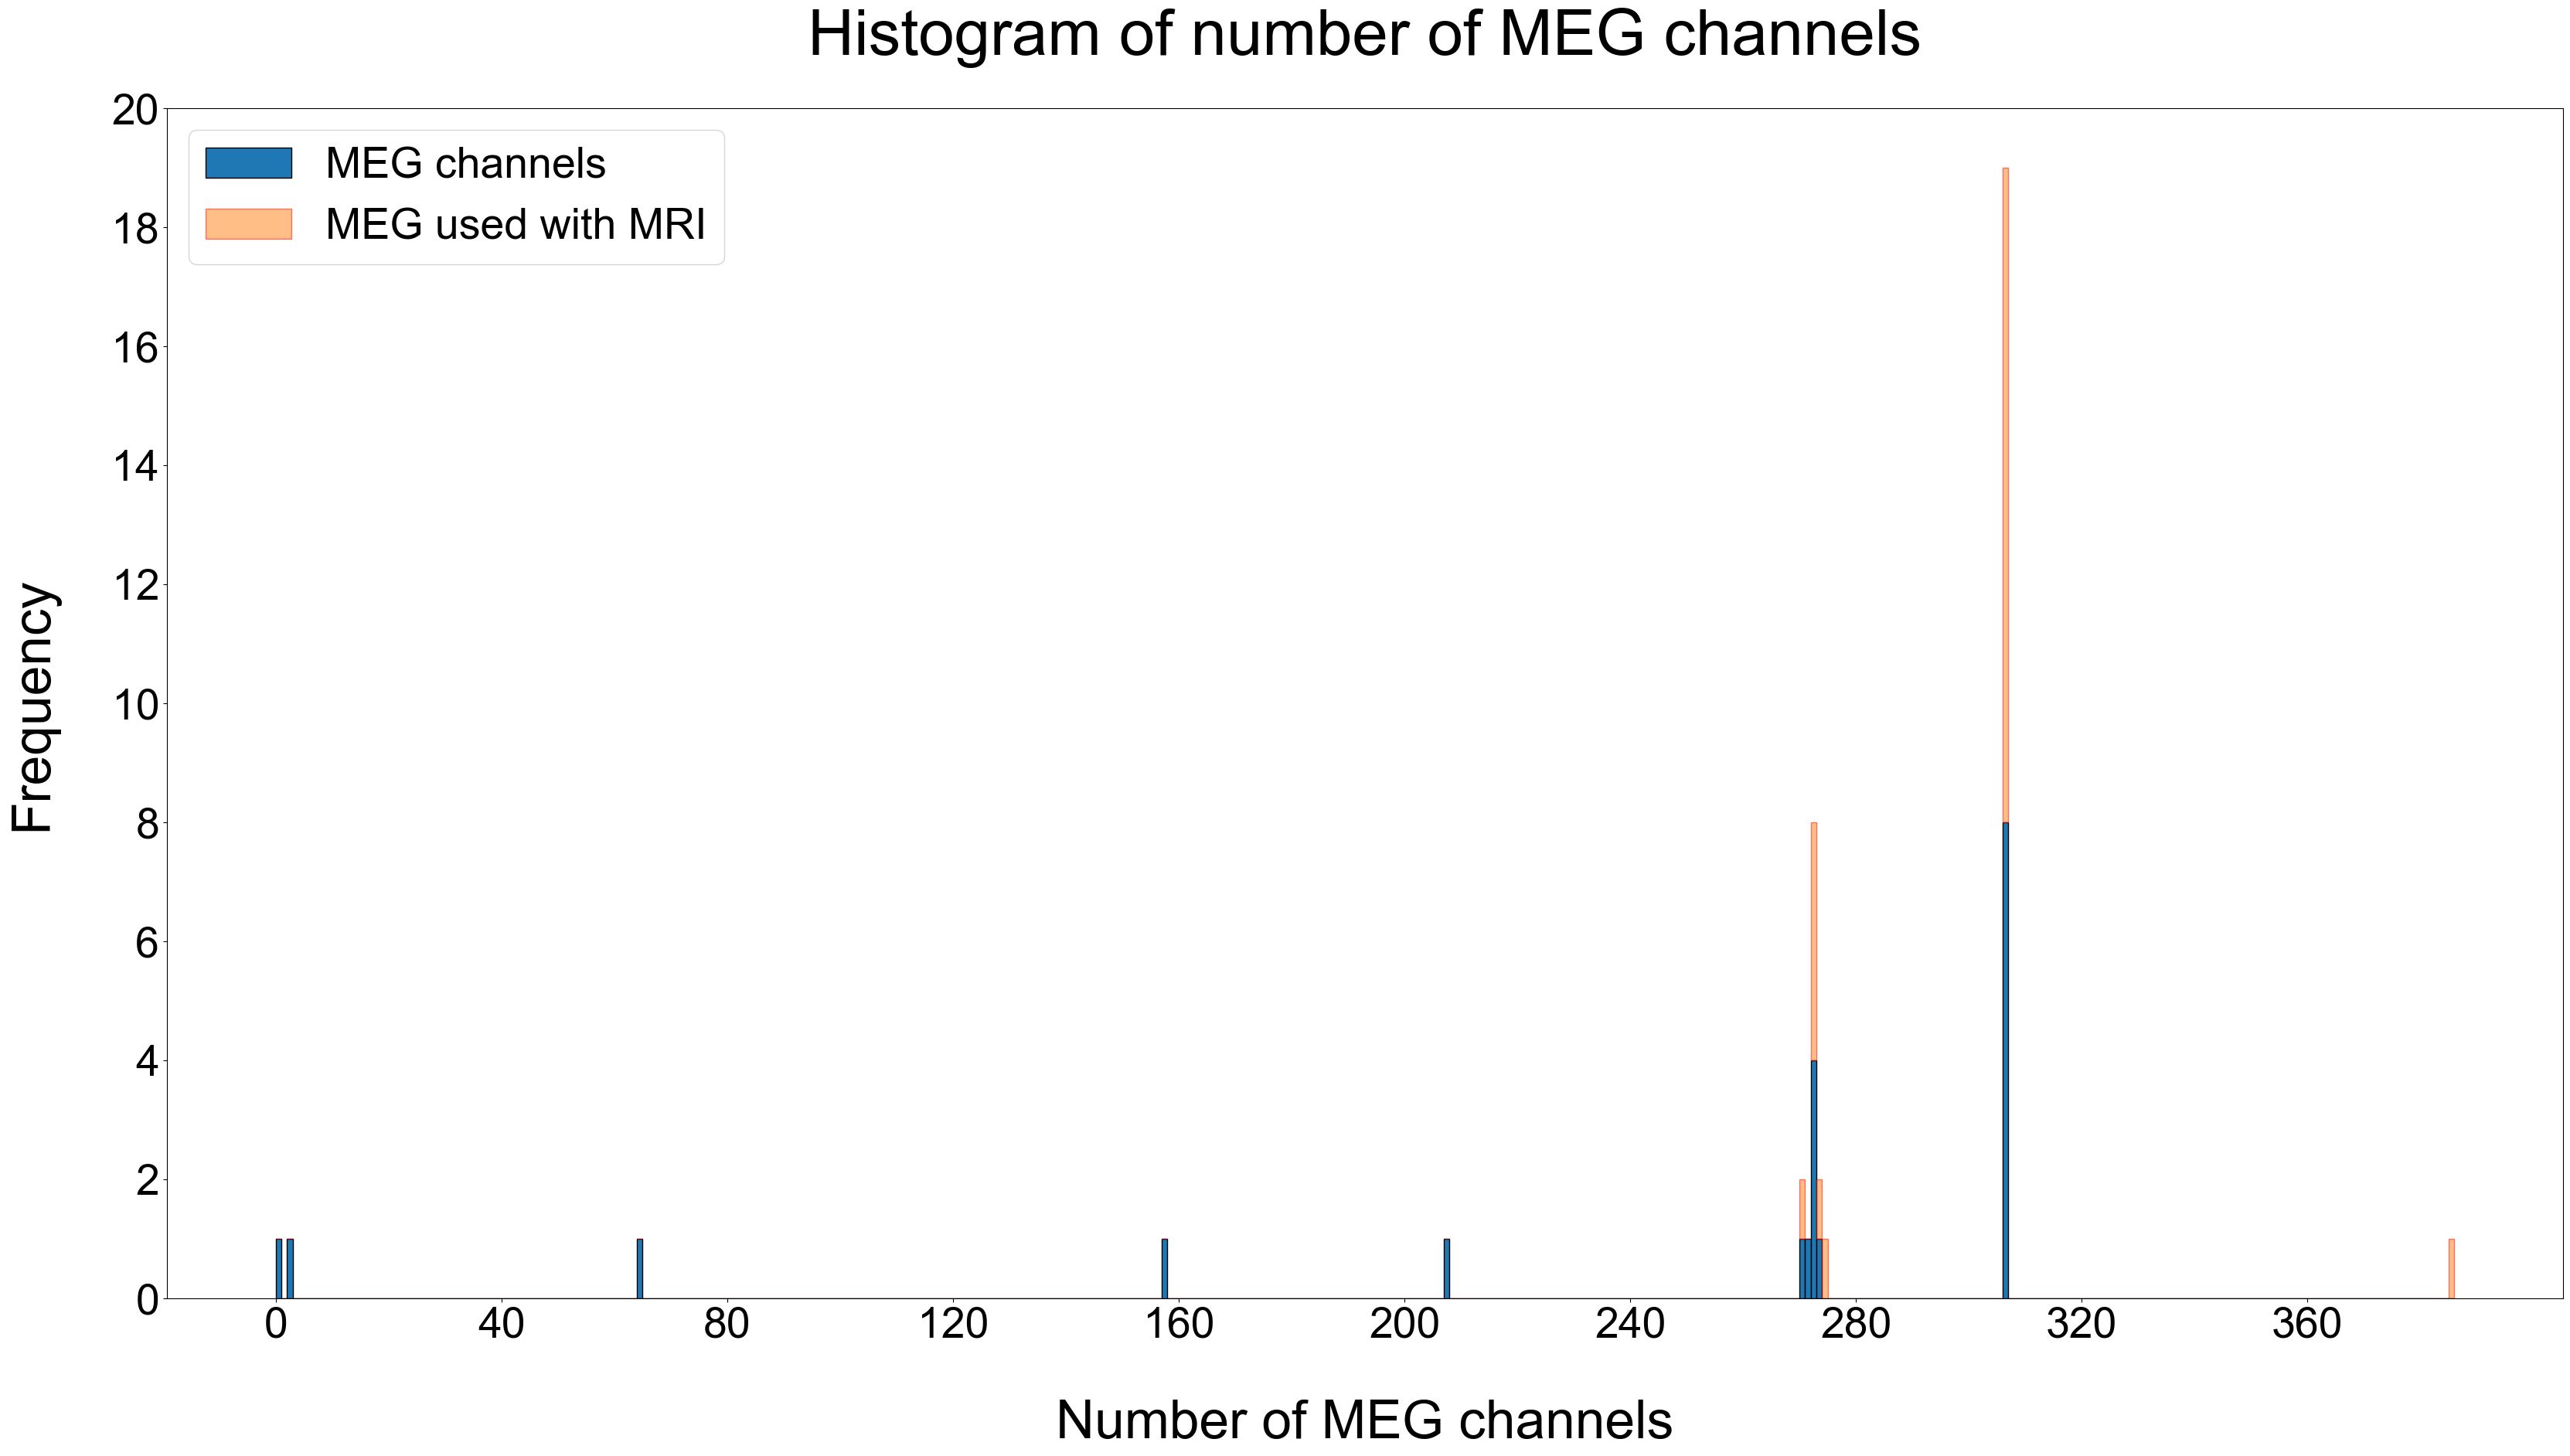

In [ ]:
df_meg_channels = df['MEG channels']
df_meg_channels.replace("n/a", "", inplace=True)
df_meg_channels.dropna()

# Convert the MEG channels to numeric, forcing errors to NaN
df_meg_channels = pd.to_numeric(df_meg_channels, errors='coerce')
df_meg_channels.dropna(inplace=True)

df_mri_channels = df[['MEG channels', 'Has MRI']]
df_mri_channels.dropna(inplace=True)
df_mri_channels.drop(columns=['Has MRI'], inplace=True)
df_mri_channels = df_mri_channels.apply(pd.to_numeric, errors='coerce')
df_mri_channels.dropna(inplace=True)

# Define the number of bins for the histogram
BIN_COUNT_MEG = int(df_meg_channels.max())  # Ensure the bins cover the range from 0 to max MEG channel count

# Set the font to Arial for all text elements
plt.rcParams['font.family'] = 'Arial'

# Create the histogram without MRI data
fig_meg, ax_meg = plt.subplots(figsize=(40, 20))  # Increase the width of the figure
hist_meg, bin_edges = np.histogram(df_meg_channels, bins=np.arange(0, BIN_COUNT_MEG + 2))  # Use np.arange to define bin edges

# Plot the MRI data on the same histogram, but at the top of each bar/bin
hist_mri, _ = np.histogram(df_mri_channels, bins=np.arange(0, BIN_COUNT_MEG + 2))
hist_meg -= hist_mri

# Plot the histogram
ax_meg.bar(bin_edges[:-1], hist_meg, width=np.diff(bin_edges), label='MEG channels', edgecolor="black", align="edge")
ax_meg.bar(bin_edges[:-1], hist_mri, width=np.diff(bin_edges), edgecolor="red", align="edge", alpha=0.5, label='MEG used with MRI', bottom=hist_meg)

ax_meg.set_xlabel('Number of MEG channels', fontsize=50, labelpad=50, fontfamily='Arial')
ax_meg.set_ylabel('Frequency', fontsize=50, labelpad=50, fontfamily='Arial')
ax_meg.set_title('Histogram of number of MEG channels', fontsize=60, pad=50, fontfamily='Arial')
ax_meg.tick_params(axis='both', which='major', labelsize=40)

# Set y-axis ticks to go up to 20
ax_meg.set_yticks(np.arange(0, 21, 2))

# Set x-axis ticks to be marked every 20
ax_meg.set_xticks(np.arange(0, max(bin_edges), 40))

ax_meg.legend(fontsize='40')

# Save the plot as a PNG and an SVG
fig_meg.savefig('results/v1.6/figure_5.2.png', format='png')
fig_meg.savefig('results/v1.6/figure_5.2.svg', format='svg')

plt.show()

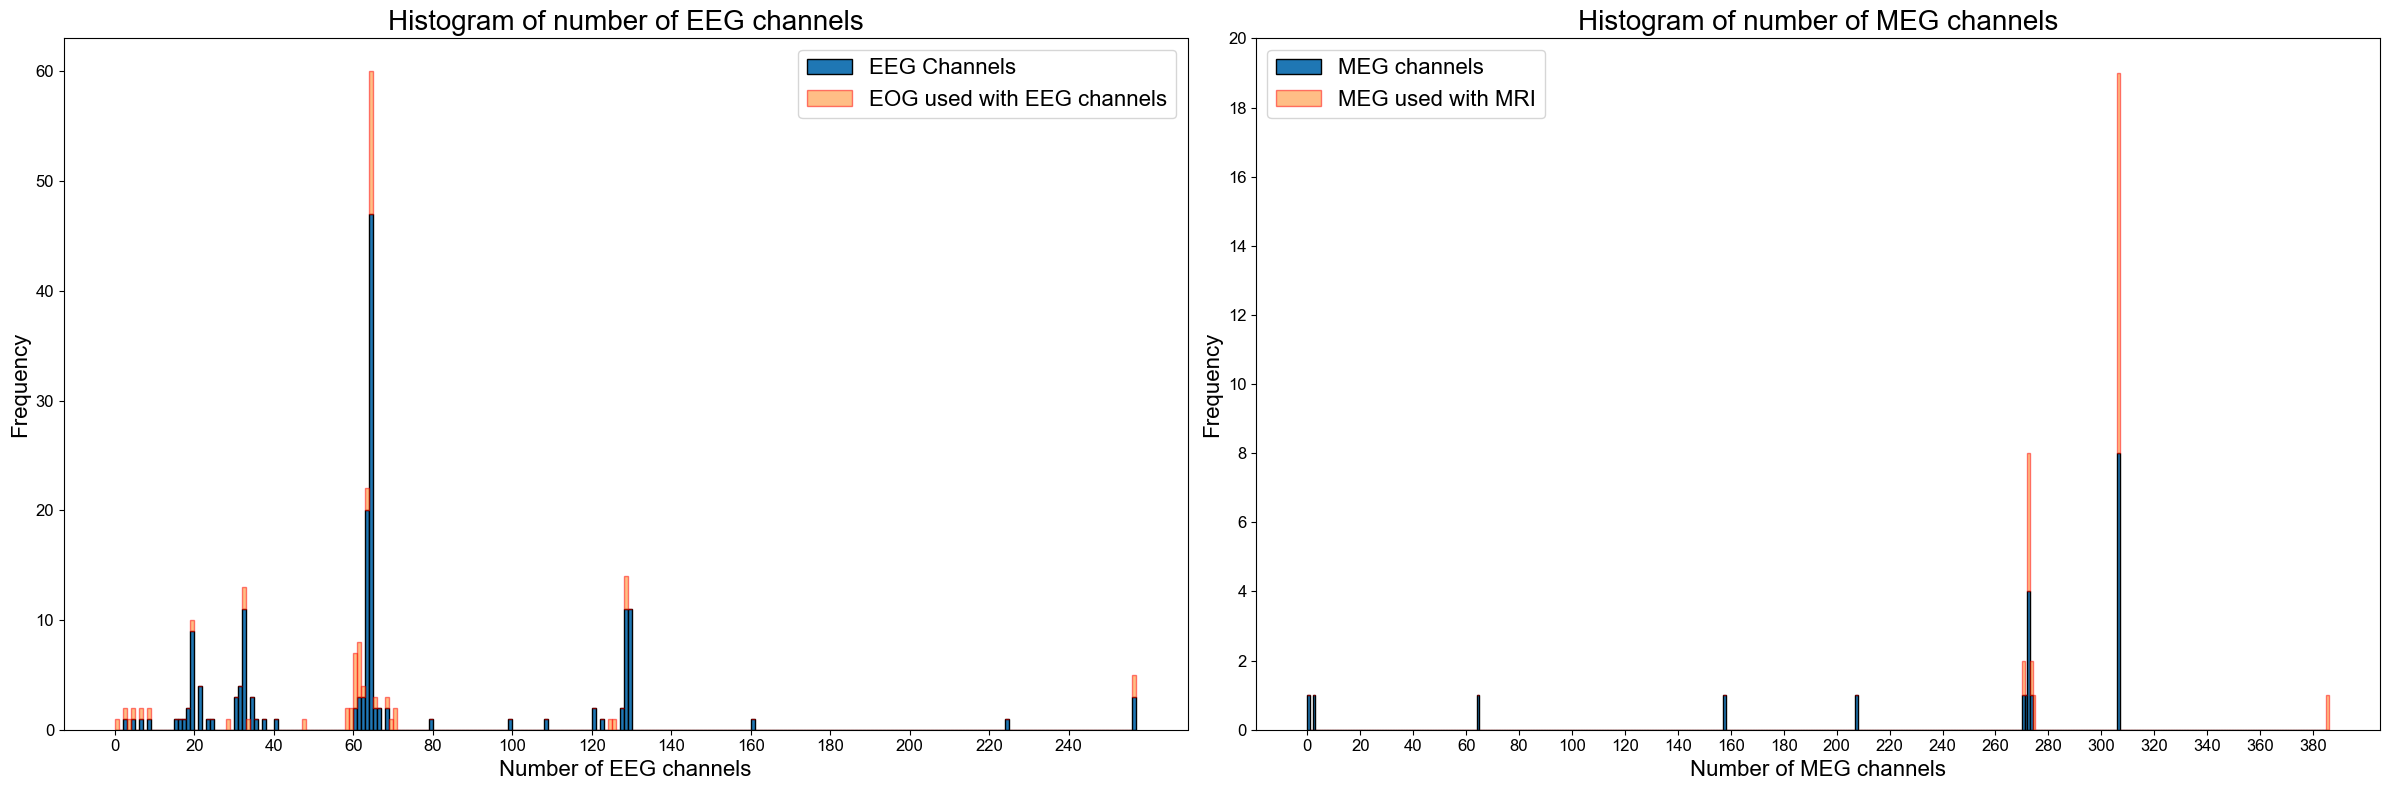

In [ ]:
# Create a figure with 2 horizontal subplots
fig, (ax_eeg, ax_meg) = plt.subplots(1, 2, figsize=(24, 8))

# EEG Plot (left subplot)
hist_eeg, bin_edges_eeg = np.histogram(df_eeg_channels, bins=BIN_COUNT_EEG)
hist_eog, _ = np.histogram(df_eog_channels, bins=bin_edges_eeg)
hist_eeg -= hist_eog
hist_eeg[-1] -= 2

ax_eeg.bar(bin_edges_eeg[:-1], hist_eeg, width=np.diff(bin_edges_eeg), 
           label='EEG Channels', edgecolor="black", align="edge")
ax_eeg.bar(bin_edges_eeg[:-1], hist_eog, width=np.diff(bin_edges_eeg), 
           edgecolor="red", align="edge", alpha=0.5, 
           label='EOG used with EEG channels', bottom=hist_eeg)
ax_eeg.set_xlabel('Number of EEG channels', fontsize=16)
ax_eeg.set_ylabel('Frequency', fontsize=16)
ax_eeg.set_title('Histogram of number of EEG channels', fontsize=20)
ax_eeg.tick_params(axis='both', which='major', labelsize=12)
ax_eeg.set_xticks(np.arange(0, max(bin_edges_eeg), 20))
ax_eeg.legend(fontsize=16)

# MEG Plot (right subplot)
hist_meg, bin_edges_meg = np.histogram(df_meg_channels, bins=np.arange(0, BIN_COUNT_MEG + 2))
hist_mri, _ = np.histogram(df_mri_channels, bins=np.arange(0, BIN_COUNT_MEG + 2))
hist_meg -= hist_mri

ax_meg.bar(bin_edges_meg[:-1], hist_meg, width=np.diff(bin_edges_meg), 
           label='MEG channels', edgecolor="black", align="edge")
ax_meg.bar(bin_edges_meg[:-1], hist_mri, width=np.diff(bin_edges_meg), 
           edgecolor="red", align="edge", alpha=0.5, 
           label='MEG used with MRI', bottom=hist_meg)
ax_meg.set_xlabel('Number of MEG channels', fontsize=16)
ax_meg.set_ylabel('Frequency', fontsize=16)
ax_meg.set_title('Histogram of number of MEG channels', fontsize=20)
ax_meg.tick_params(axis='both', which='major', labelsize=12)
ax_meg.set_yticks(np.arange(0, 21, 2))
ax_meg.set_xticks(np.arange(0, max(bin_edges_meg), 20))
ax_meg.legend(fontsize=16)

plt.tight_layout()

# Save the combined plot
fig.savefig('results/v1.5/figure_5.png', format='png', bbox_inches='tight')
fig.savefig('results/v1.5/figure_5.svg', format='svg', bbox_inches='tight')

plt.show()


In [ ]:
# Count the number of EEG datasets that used 64 channels
eeg_64_channels_count = eeg_datasets[eeg_datasets['EEG channels'] == 64].shape[0]

# Total number of EEG datasets
total_eeg_datasets = total_eeg_studies

# Count the frequency of each unique value in the 'EEG channels' column
channels_frequency = eeg_datasets['EEG channels'].value_counts().sort_values(ascending=False)

print("Channels by frequency in descending order:")
print(channels_frequency)

print(f"Number of EEG datasets that used 64 channels: {eeg_64_channels_count}")
print(f"Total number of EEG datasets: {total_eeg_datasets}")

Channels by frequency in descending order:
EEG channels
64.0     60
63.0     22
128.0    14
32.0     13
129.0    11
19.0     10
61.0      7
256.0     5
60.0      4
31.0      4
62.0      4
34.0      3
68.0      3
30.0      3
65.0      3
4.0       2
70.0      2
257.0     2
6.0       2
58.0      2
59.0      2
127.0     2
66.0      2
120.0     2
18.0      2
21.0      2
69.0      1
108.0     1
40.0      1
33.0      1
224.0     1
16.0      1
47.0      1
23.0      1
35.0      1
15.0      1
124.0     1
37.0      1
28.0      1
17.0      1
8.0       1
125.0     1
122.0     1
160.0     1
79.0      1
24.0      1
99.0      1
Name: count, dtype: int64
Number of EEG datasets that used 64 channels: 60
Total number of EEG datasets: 220


In [ ]:
# List of EEG channel counts to analyze
channel_counts = [19, 32, 61, 63, 64, 128, 129, 256]

# Iterate through each channel count and calculate the percentage
for count in channel_counts:
    # Filter EEG datasets with the specified number of channels
    eeg_filtered = eeg_datasets[eeg_datasets['EEG channels'] == count]

    # Filter datasets with EOG data
    eeg_with_eog = eeg_filtered[eeg_filtered['EOG channels'].notna()]

    # Calculate the percentage
    if len(eeg_filtered) > 0:
        percentage_with_eog = (len(eeg_with_eog) / len(eeg_filtered)) * 100
    else:
        percentage_with_eog = 0

    print(f"Percentage of EEG datasets with {count} channels that also recorded EOG data: {percentage_with_eog:.2f}%")

Percentage of EEG datasets with 19 channels that also recorded EOG data: 10.00%
Percentage of EEG datasets with 32 channels that also recorded EOG data: 15.38%
Percentage of EEG datasets with 61 channels that also recorded EOG data: 71.43%
Percentage of EEG datasets with 63 channels that also recorded EOG data: 9.09%
Percentage of EEG datasets with 64 channels that also recorded EOG data: 21.67%
Percentage of EEG datasets with 128 channels that also recorded EOG data: 21.43%
Percentage of EEG datasets with 129 channels that also recorded EOG data: 0.00%
Percentage of EEG datasets with 256 channels that also recorded EOG data: 40.00%


In [ ]:
# Filter MEG datasets
meg_datasets = df[df['MEG Modality'].notna()]

# Filter for datasets with 272 channels and MRI
meg_272_mri = meg_datasets[(meg_datasets['MEG channels'] == 272) & (meg_datasets['Has MRI'] == 'x')]
num_272_mri = len(meg_272_mri)

# Filter for datasets with 306 channels and MRI
meg_306_mri = meg_datasets[(meg_datasets['MEG channels'] == 306) & (meg_datasets['Has MRI'] == 'x')]
num_306_mri = len(meg_306_mri)

# Total number of MEG datasets
total_meg_datasets = len(meg_datasets)

# Calculate percentages
percentage_272_mri = (num_272_mri / total_meg_datasets) * 100 if total_meg_datasets > 0 else 0
percentage_306_mri = (num_306_mri / total_meg_datasets) * 100 if total_meg_datasets > 0 else 0

print(f"Number of MEG datasets with 272 channels and MRI: {num_272_mri}")
print(f"Percentage of MEG datasets with 272 channels and MRI: {percentage_272_mri:.2f}%")
print(f"Number of MEG datasets with 306 channels and MRI: {num_306_mri}")
print(f"Percentage of MEG datasets with 306 channels and MRI: {percentage_306_mri:.2f}%")

Number of MEG datasets with 272 channels and MRI: 4
Percentage of MEG datasets with 272 channels and MRI: 10.00%
Number of MEG datasets with 306 channels and MRI: 10
Percentage of MEG datasets with 306 channels and MRI: 25.00%


### Figure 7

Figure 5 - EEG channel histogram (see which are most common)

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_30748/2548039866.py:28: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





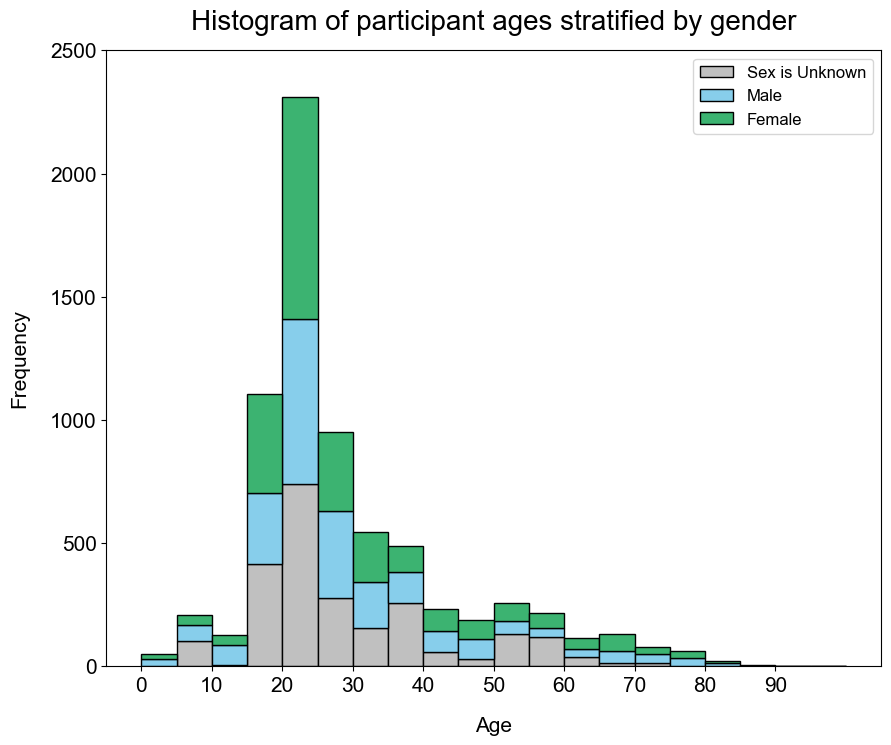

In [ ]:
import os
from io import StringIO
import pandas as pd

# Create a DataFrame with age and sex as parameters
df_ages_sexes = pd.DataFrame(columns=['age', 'sex'])

# Iterate through each file in the directory
for filename in os.listdir('data/participant_ages'):
    if filename.endswith('.txt'):
        # Read the file into a DataFrame
        file_path = os.path.join('data/participant_ages', filename)
        df_temp = pd.read_csv(file_path, sep='\t')

        # Check if both 'age' and 'sex' columns exist in df_temp
        if 'age' in df_temp.columns and 'sex' in df_temp.columns:
            # Concatenate the 'age' and 'sex' columns to the df_ages_sexes DataFrame
            df_ages_sexes = pd.concat([df_ages_sexes, df_temp[['age', 'sex']]], ignore_index=True)
        elif 'age' in df_temp.columns and 'sex' not in df_temp.columns:
            # Add the 'age' column values to df_ages_sexes with NaN for 'sex'
            df_temp['sex'] = np.nan
            df_ages_sexes = pd.concat([df_ages_sexes, df_temp[['age', 'sex']]], ignore_index=True)

# post-processing
df_ages_sexes['age'] = pd.to_numeric(df_ages_sexes['age'], errors='coerce')
df_ages_sexes = df_ages_sexes.dropna(subset=['age'])
df_ages_sexes['sex'] = df_ages_sexes['sex'].str.lower()
df_ages_sexes['sex'].replace({'male': 'm', 'female': 'f', 'w': 'f'}, inplace=True)

# Create a stacked histogram for age=null, male, and female

# Define bins
bins = np.arange(0, 105, 5)

# Define the colors for each category
colors = ['silver', 'skyblue', 'mediumseagreen', 'lightcoral']

# Create the histogram for age=null
df_ages_no_sex = df_ages_sexes[df_ages_sexes['sex'].isna()]
hist_no_sex, bin_edges = np.histogram(df_ages_no_sex['age'], bins=bins)

# Create the histogram for males
df_ages_male = df_ages_sexes[df_ages_sexes['sex'] == 'm']
hist_male, _ = np.histogram(df_ages_male['age'], bins=bin_edges)

# Create the histogram for females
df_ages_female = df_ages_sexes[df_ages_sexes['sex'] == 'f']
hist_female, _ = np.histogram(df_ages_female['age'], bins=bin_edges)

# Create the histogram for nonbinary
df_ages_nb = df_ages_sexes[df_ages_sexes['sex'] == 'nb']
hist_nb, _ = np.histogram(df_ages_nb['age'], bins=bin_edges)

# Set the font to Arial for all text elements
plt.rcParams['font.family'] = 'Arial'

# Plot the stacked histogram
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(bin_edges[:-1], hist_no_sex, width=np.diff(bin_edges), edgecolor="black", 
       align="edge", color=colors[0], label='Sex is Unknown')
ax.bar(bin_edges[:-1], hist_male, width=np.diff(bin_edges), edgecolor="black", 
       align="edge", color=colors[1], label='Male', bottom=hist_no_sex)
ax.bar(bin_edges[:-1], hist_female, width=np.diff(bin_edges), edgecolor="black", 
       align="edge", color=colors[2], label='Female', bottom=hist_no_sex + hist_male)

# Set all text properties to use Arial font
ax.set_xlabel('Age', fontfamily='Arial', fontsize=15, labelpad=15)
ax.set_ylabel('Frequency', fontfamily='Arial', fontsize=15, labelpad=15)
ax.set_title('Histogram of participant ages stratified by gender', 
             fontfamily='Arial', fontsize=20, pad=15)
ax.set_ylim(0, 2500)  # Set y-axis limit to 2500
ax.set_xticks(np.arange(0, max(bin_edges), 10))  # Set x-axis ticks every 5
ax.tick_params(axis='both', which='major', labelsize=15)

# Use Arial font for the legend
legend = ax.legend(prop={'family': 'Arial', 'size': 12})

# Save the plot as a PNG and an SVG
fig.savefig('results/v1.6/figure_6.png', format='png')
fig.savefig('results/v1.6/figure_6.svg', format='svg')

plt.show()


In [ ]:
count_20_to_30 = df_ages_sexes[(df_ages_sexes['age'] >= 50) & (df_ages_sexes['age'] < 100)].shape[0]
print(f'Number of values in df_ages_sexes["age"] between 20 to 30: {count_20_to_30}')
print("Df age sexes shape:", df_ages_sexes.shape)
count_greater_than_50 = df_ages_sexes[df_ages_sexes['age'] >= 50].shape[0]
print(f'Number of values in df_ages_sexes["age"] greater than 50: {count_greater_than_50}')


Number of values in df_ages_sexes["age"] between 20 to 30: 885
Df age sexes shape: (7093, 2)
Number of values in df_ages_sexes["age"] greater than 50: 885


In [ ]:
# Count the total number of datasets
total_datasets = len(df)

print("Total number of datasets:", total_datasets)

# Count the number of datasets with 'Age range' as null, NaN, or analogous
datasets_without_age = df['Age range'].isna().sum()

# Calculate the percentage
percentage_without_age = (datasets_without_age / total_datasets) * 100

print(f"Number of datasets without age specified: {datasets_without_age}")
print(f"Percentage of datasets without age specified: {percentage_without_age:.2f}%")
print(f"Percentage of datasets with age specified: {100 - percentage_without_age:.2f}%")

Total number of datasets: 292
Number of datasets without age specified: 90
Percentage of datasets without age specified: 30.82%
Percentage of datasets with age specified: 69.18%


In [ ]:
100-

In [ ]:
num_females = df_ages_sexes[df_ages_sexes['sex'] == 'f'].shape[0]
print(f'Number of female values in df_ages_sexes: {num_females}')
num_males = df_ages_sexes[df_ages_sexes['sex'] == 'm'].shape[0]
print(f'Number of male values in df_ages_sexes: {num_males}')
num_nb = df_ages_sexes[df_ages_sexes['sex'] == 'nb'].shape[0]
print(f'Number of nonbinary values in df_ages_sexes: {num_nb}')

total_participants = num_females + num_males + num_nb
percentage_females = (num_females / total_participants) * 100
percentage_males = (num_males / total_participants) * 100

print(f"Percentage of females: {percentage_females:.2f}%")
print(f"Percentage of males: {percentage_males:.2f}%")

Number of female values in df_ages_sexes: 2505
Number of male values in df_ages_sexes: 2227
Number of nonbinary values in df_ages_sexes: 1
Percentage of females: 52.93%
Percentage of males: 47.05%


In [ ]:
''' 

Old method of creating histogram edges relying on age ranges. 

'''

# df_fig7 = df['Age range']
# df_fig7.dropna(inplace=True)
# df_fig7.str.replace(r'\s+', '', regex=True)
# df_fig7_split = df_fig7.str.split('-', expand=True)
# df_fig7_split = df_fig7_split.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# df_fig7_split.dropna(inplace=True)
# df_fig7_split = df_fig7_split.apply(pd.to_numeric, errors='coerce')

# # Define the bins
# bins = np.arange(0, 105, 5)
# bin_counts = np.zeros(len(bins) - 1)

# # Iterate through each row in df_fig7_split
# for _, row in df_fig7_split.iterrows():
#     start_age, end_age = row[0], row[1]
#     for i in range(len(bins) - 1):
#         if bins[i] < start_age < bins[i + 1] or bins[i] < end_age < bins[i + 1] or (start_age <= bins[i] and end_age >= bins[i + 1]):
#             bin_counts[i] += 1

# # Create a DataFrame for the histogram
# hist_data = pd.DataFrame({'Age Range': bins[:-1], 'Count': bin_counts})

# # Create the histogram using plotly
# fig = px.bar(hist_data, x='Age Range', y='Count', title='Histogram of Age Ranges')
# fig.update_layout(
#     xaxis_title='Age Range',
#     yaxis_title='Count',
#     xaxis=dict(tickmode='array', tickvals=bins, ticktext=[f'{int(b)}-{int(b+5)}' for b in bins[:-1]])
# )
# fig.show()

# # pd.set_option('display.max_rows', None)
# # print(df_fig7_split)

' \n\nOld method of creating histogram edges relying on age ranges. \n\n'

### Figure 8

participants x modality


In [ ]:
df_fig8 = df[['Participants',
              'FOR FIGURE - modality of exp']]
df_fig8.dropna(inplace=True)

modalities_fig8 = df_fig8['FOR FIGURE - modality of exp'].unique()

# Initialize the dictionary with empty dataframes
dfs_by_modalities_fig8 = {modality: pd.DataFrame(columns=df_fig8.columns) for modality in modalities_fig8}

# Populate the dataframes
for index, row in df_fig8.iterrows():
    for modality in modalities_fig8:
        if modality in str(row['FOR FIGURE - modality of exp']).lower():
            dfs_by_modalities_fig8[modality].loc[len(dfs_by_modalities_fig8[modality])] = row

# Combine all dataframes in dfs_by_modalities_fig8 into a single dataframe
combined_df = pd.concat(dfs_by_modalities_fig8.values(), keys=dfs_by_modalities_fig8.keys()).reset_index(level=0).rename(columns={'level_0': 'Modality'})

# Convert Participants to numeric for sorting
combined_df['Participants'] = pd.to_numeric(combined_df['Participants'], errors='coerce')

# # Create the strip plot with sorted x-axis
# fig_strip = px.strip(combined_df.sort_values(by='Participants'), x='Participants', y='Modality', title='Participants by Modality', stripmode='overlay')

# Create a log version of fig_strip
fig_strip_log = px.strip(combined_df.sort_values(by='Participants'), x='Participants', y='Modality', title='Number of participants in each study per modality', stripmode='overlay')
fig_strip_log.update_xaxes(type="log", tickvals=[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])

# Update layout for title and axis fonts
fig_strip_log.update_layout(
    title={
        'text': 'Number of participants in each study per modality',
        'x': 0.5,  # Center the title
        'xanchor': 'center',
        'font': {'size': 48}  # Increase title font size
    },
    xaxis_title={
        'text': 'Participants',
        'font': {'size': 36}  # Increase x-axis title font size
    },
    yaxis_title={
        'text': 'Modality',
        'font': {'size': 36}  # Increase y-axis title font size
    },
    yaxis=dict(
        tickfont=dict(size=24)  # Increase the font size of the rows
    ),
    xaxis=dict(
        tickfont=dict(size=24)  # Increase the font size of the columns
    )
)

# # Filter out the outlier
# filtered_combined_df = combined_df[combined_df['Participants'] != 2951]

# # Create the second strip plot without the outlier
# fig_strip_no_outlier = px.strip(filtered_combined_df.sort_values(by='Participants'), 
#                                 x='Participants', y='Modality', 
#                                 title='Participants by Modality (Without Outlier)', 
#                                 stripmode='overlay')

# # Create a log version of the second fig_strip without the outlier
# fig_strip_no_outlier_log = px.strip(filtered_combined_df.sort_values(by='Participants'), x='Participants', y='Modality', title='Participants by Modality (Without Outlier) (log)', stripmode='overlay')
# fig_strip_no_outlier_log.update_xaxes(type="log")

# Set the font to Arial for Plotly figures
fig_strip_log.update_layout(
    font=dict(family="Arial"),
    title=dict(font=dict(family="Arial")),
    xaxis=dict(title=dict(font=dict(family="Arial"))),
    yaxis=dict(title=dict(font=dict(family="Arial")))
)

# fig_strip.show()
fig_strip_log.show()
# fig_strip_no_outlier.show()
# fig_strip_no_outlier_log.show()

fig_strip_log.write_image("results/v1.6/figure_7.svg", format='svg')
fig_strip_log.write_image("results/v1.6/figure_7.png", format='png')

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_30748/1531464691.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_fig8 = df[['Participants',
              'FOR FIGURE - modality of exp']]
df_fig8.dropna(inplace=True)

modalities_fig8 = df_fig8['FOR FIGURE - modality of exp'].unique()

# Initialize the dictionary with empty dataframes
dfs_by_modalities_fig8 = {modality: pd.DataFrame(columns=df_fig8.columns) for modality in modalities_fig8}

# Populate the dataframes
for index, row in df_fig8.iterrows():
    for modality in modalities_fig8:
        if modality in str(row['FOR FIGURE - modality of exp']).lower():
            dfs_by_modalities_fig8[modality].loc[len(dfs_by_modalities_fig8[modality])] = row

# Combine all dataframes in dfs_by_modalities_fig8 into a single dataframe
combined_df = pd.concat(dfs_by_modalities_fig8.values(), keys=dfs_by_modalities_fig8.keys()).reset_index(level=0).rename(columns={'level_0': 'Modality'})

# Convert Participants to numeric for sorting
combined_df['Participants'] = pd.to_numeric(combined_df['Participants'], errors='coerce')

# Create the strip plot with sorted x-axis
fig_strip = px.strip(combined_df.sort_values(by='Participants'), x='Participants', y='Modality', title='Participants by Modality', stripmode='overlay')

# Create a log version of fig_strip
fig_strip_log = px.strip(combined_df.sort_values(by='Participants'), x='Participants', y='Modality', title='Participants by Modality (log)', stripmode='overlay')
fig_strip_log.update_xaxes(type="log")

# Set the font to Arial for Plotly figures and define height and width
fig_strip_log.update_layout(
    font=dict(family="Arial", size=18),
    title=dict(
        text='Number of participants in each study per modality',
        font=dict(family="Arial", size=24),
        x=0.5,  # Center the title
        xanchor='center'
    ),
    xaxis=dict(
        title=dict(text='Number of Participants (Log Scale)', font=dict(family="Arial", size=20)),
        tickfont=dict(size=16)
    ),
    yaxis=dict(
        title=dict(text='Experiment Modality', font=dict(family="Arial", size=20)),
        tickfont=dict(size=16)
    ),
    height=800,  # Define the height
    width=1200   # Define the width
)
fig_strip_log.update_xaxes(type="log", tickvals=[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000])
fig_strip_log.update_traces(marker=dict(size=12))


fig_strip_log.show()

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_30748/2998533072.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig_strip_log.write_image("results/v1.6/figure_7.svg", format='svg')
fig_strip_log.write_image("results/v1.6/figure_7.png", format='png')

In [ ]:
participants_per_modality = combined_df.groupby('Modality')['Participants'].sum().sort_values(ascending=False)
datasets_per_modality = combined_df.groupby('Modality').size().sort_values(ascending=False)

total_participants = participants_per_modality.sum()
percentages = (participants_per_modality / total_participants) * 100

print(participants_per_modality)
print(percentages)
print(datasets_per_modality)
print('Total participants:', total_participants)

Modality
visual           9046.0
auditory         1578.0
multisensory     1359.0
resting state    1101.0
sleep             333.0
motor             269.0
anasthesia        105.0
unknown            98.0
other              95.0
tactile            49.0
Name: Participants, dtype: float64
Modality
visual           64.462339
auditory         11.244923
multisensory      9.684316
resting state     7.845792
sleep             2.372978
motor             1.916910
anasthesia        0.748236
unknown           0.698354
other             0.676976
tactile           0.349177
Name: Participants, dtype: float64
Modality
visual           136
auditory          49
multisensory      45
resting state     24
motor             13
sleep              7
anasthesia         5
other              5
unknown            5
tactile            3
dtype: int64
Total participants: 14033.0


In [ ]:
datasets_per_modality = combined_df.groupby('Modality').size()
print(datasets_per_modality)
print('total sum: ', datasets_per_modality.sum())

Modality
anasthesia         5
auditory          49
motor             13
multisensory      45
other              5
resting state     24
sleep              7
tactile            3
unknown            5
visual           136
dtype: int64
total sum:  292


In [ ]:
# Filter the combined_df for visual modality
visual_df = combined_df[combined_df['Modality'] == 'visual']

# Find the smallest and largest number of participants in the visual datasets
smallest_visual_participants = visual_df['Participants'].min()
largest_visual_participants = visual_df['Participants'].max()

print(f'Smallest number of participants in visual dataset: {smallest_visual_participants}')
print(f'Largest number of participants in visual dataset: {largest_visual_participants}')

Smallest number of participants in visual dataset: 1.0
Largest number of participants in visual dataset: 2951.0


In [ ]:
9201/14291

0.643831782240571

### Figure 9
create a figure of the various disorders versus number of participants, make it in log space

In [ ]:
df_fig9 = df['FOR FIG - Type Subject']

df_fig9.replace('?', np.nan, inplace=True)
df_fig9.dropna(inplace=True)

# Calculate the frequency of each unique value in df_fig9
value_counts = df_fig9.value_counts()

# # Create a bar plot (matplotlib version)
# plt.figure(figsize=(12, 6))
# value_counts.plot(kind='bar', log=False)
# plt.xlabel('Type of Subject')
# plt.ylabel('Frequency')
# plt.title('Number of studies on various subject types')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# Create a bar plot using plotly
fig = px.bar(value_counts, x=value_counts.index, y=value_counts.values, log_y=False)
fig.update_layout(
    title={
        'text': 'Number of Studies vs Subject Type',
        'x': 0.5,  # Center the title
        'xanchor': 'center'
    },
    xaxis_title='Type of Subject',
    yaxis_title='Frequency',
    xaxis_tickangle=-45,
    font=dict(color='black', size=14)  # Set the text color to black and font size to 14
)

fig.write_image("results/v1.5/figure_8.svg", format='svg')
fig.write_image("results/v1.5/figure_8.png", format='png')
fig.show()


#### Figure 10 -- new version of figure 8

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_34296/1900009229.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



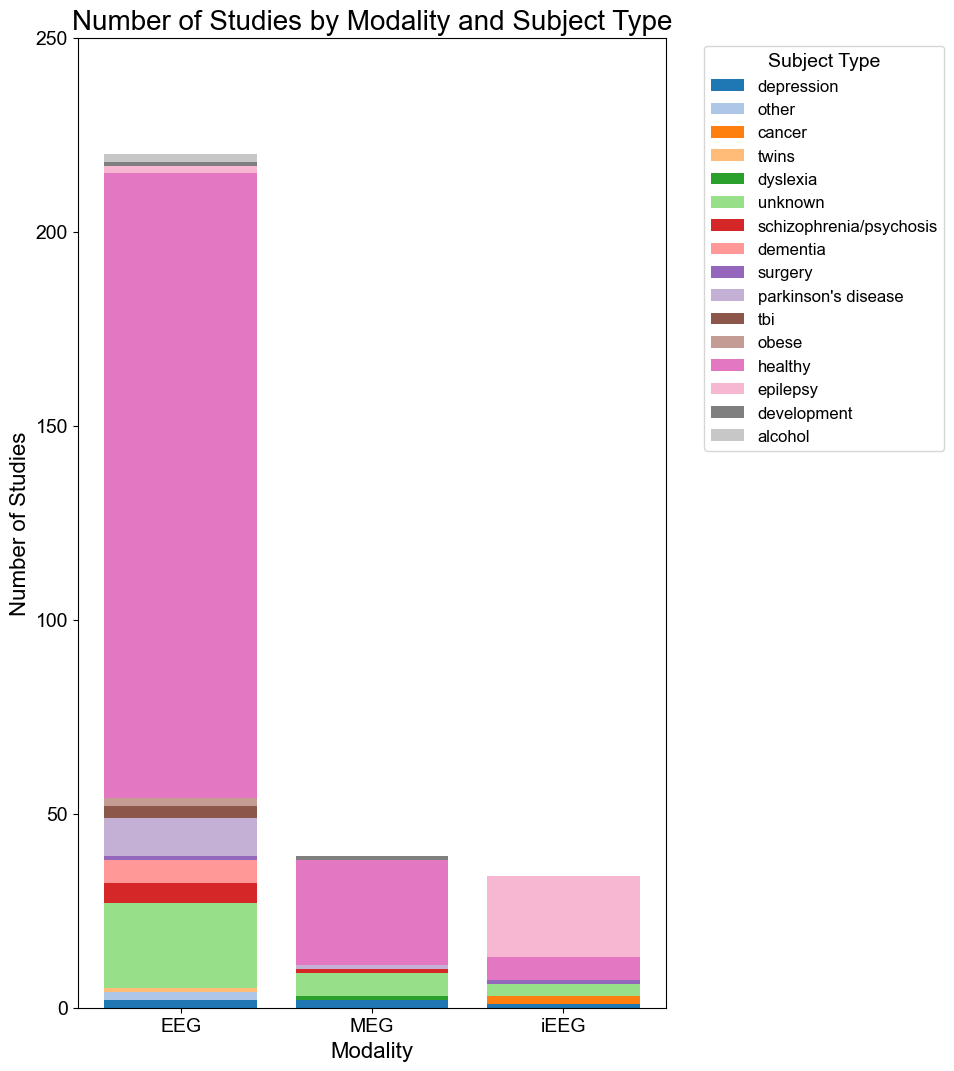

In [26]:
from matplotlib.cm import get_cmap

# Filter rows where 'EEG Modality' is not null or empty
df_eeg = df[df['EEG Modality'].notna() & (df['EEG Modality'] != '')]
df_meg = df[df['MEG Modality'].notna() & (df['MEG Modality'] != '')]
df_ieeg = df[df['iEEG Modality'].notna() & (df['iEEG Modality'] != '')]

# Count the number of studies for each modality
eeg_counts = df_eeg['FOR FIG - Type Subject'].value_counts().to_dict()
meg_counts = df_meg['FOR FIG - Type Subject'].value_counts().to_dict()
ieeg_counts = df_ieeg['FOR FIG - Type Subject'].value_counts().to_dict()

# Combine all unique subject types from the three modalities
all_subject_types = set(eeg_counts.keys()).union(set(meg_counts.keys()), set(ieeg_counts.keys()))
data = {subject: [eeg_counts.get(subject, 0), meg_counts.get(subject, 0), ieeg_counts.get(subject, 0)] for subject in all_subject_types}
df_subject_counts = pd.DataFrame(data, index=['EEG', 'MEG', 'iEEG']).T

# Create a stacked bar plot
x = np.arange(len(df_subject_counts.columns))  # X-axis positions
bar_width = 0.8  # Width of the bars

plt.figure(figsize=(10, 10))

# Use a distinct colormap with enough colors
cmap = get_cmap('tab20')  # Use 'tab20' for 20 distinct colors
colors = [cmap(i) for i in range(len(df_subject_counts.index))]

# # Sort the data by the total counts across modalities in descending order
# df_subject_counts['Total'] = df_subject_counts.sum(axis=1)
# df_subject_counts = df_subject_counts.sort_values(by='Total', ascending=False)
# df_subject_counts.drop(columns=['Total'], inplace=True)

# Update x-axis positions after sorting
x = np.arange(len(df_subject_counts.columns))

# Plot each subject type as a stacked bar
bottom = np.zeros(len(x))
for i, subject_type in enumerate(df_subject_counts.index):
    plt.bar(x, df_subject_counts.loc[subject_type], bar_width, label=subject_type, bottom=bottom, color=colors[i])
    bottom += df_subject_counts.loc[subject_type]

# Add labels and title
plt.xticks(x, df_subject_counts.columns, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Modality', fontsize=16)
plt.ylabel('Number of Studies', fontsize=16)
plt.legend(title='Subject Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.ylim(0, 250)

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Center the title and graph
plt.title('Number of Studies by Modality and Subject Type', fontsize=20, loc='center')
plt.gca().set_position([0.1, 0.2, 0.8, 0.6])  # Adjust the position of the graph to center it

# # Save the plot as PNG and SVG
plt.savefig('results/v1.6/figure_8_v2.png', format='png', bbox_inches='tight')
plt.savefig('results/v1.6/figure_8_v2.svg', format='svg', bbox_inches='tight')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_34296/3842011299.py:30: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



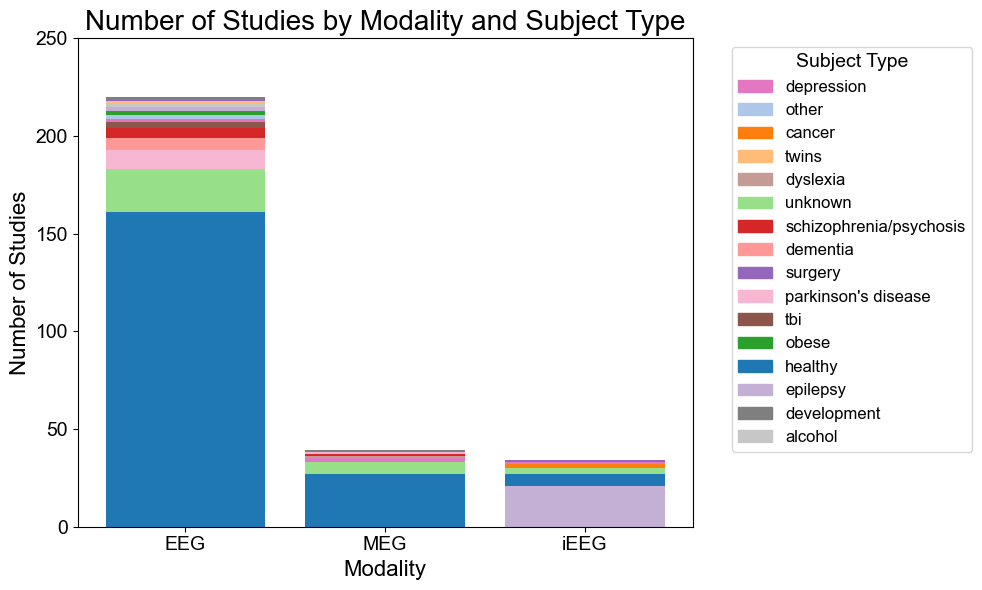

In [53]:
from matplotlib.cm import get_cmap

# Filter rows where modality columns are not null or empty
df_eeg = df[df['EEG Modality'].notna() & (df['EEG Modality'] != '')]
df_meg = df[df['MEG Modality'].notna() & (df['MEG Modality'] != '')]
df_ieeg = df[df['iEEG Modality'].notna() & (df['iEEG Modality'] != '')]

# Count the number of studies for each modality
eeg_counts = df_eeg['FOR FIG - Type Subject'].value_counts().to_dict()
meg_counts = df_meg['FOR FIG - Type Subject'].value_counts().to_dict()
ieeg_counts = df_ieeg['FOR FIG - Type Subject'].value_counts().to_dict()

# Combine all unique subject types from the three modalities
all_subject_types = set(eeg_counts.keys()).union(set(meg_counts.keys()), set(ieeg_counts.keys()))
data = {subject: [eeg_counts.get(subject, 0), meg_counts.get(subject, 0), ieeg_counts.get(subject, 0)] for subject in all_subject_types}
df_subject_counts = pd.DataFrame(data, index=['EEG', 'MEG', 'iEEG']).T

# For each modality, sort the subjects by count in descending order
sorted_subject_counts = {}
for modality in df_subject_counts.columns:
    sorted_subject_counts[modality] = df_subject_counts[modality].sort_values(ascending=False)

# Create a stacked bar plot
x = np.arange(len(df_subject_counts.columns))  # X-axis positions
bar_width = 0.8  # Width of the bars

plt.figure(figsize=(10, 6))

# Use a distinct colormap with enough colors
cmap = get_cmap('tab20')  # Use 'tab20' for 20 distinct colors
# colors = [cmap(i) for i in range(len(df_subject_counts.index))]
swaps = [(12, 0), (4, 11), (13, 9)]
colors = [cmap(i) for i in range(16)]
for a, b in swaps:
    colors[a], colors[b] = colors[b], colors[a]

# For each modality, plot the bars in descending order by count
for i, modality in enumerate(df_subject_counts.columns):
    bottom = 0
    # Sort the subjects for this modality by count in descending order
    for j, (subject_type, count) in enumerate(sorted_subject_counts[modality].items()):
        if count > 0:  # Only plot if count is positive
            plt.bar(i, count, bar_width, bottom=bottom, label=f"{subject_type}" if i == 0 and bottom == 0 else "", 
                    color=colors[list(df_subject_counts.index).index(subject_type)])
            bottom += count

# Add labels and title
plt.xticks(x, df_subject_counts.columns, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Modality', fontsize=16)
plt.ylabel('Number of Studies', fontsize=16)
plt.title('Number of Studies by Modality and Subject Type', fontsize=20, loc='center')
plt.ylim(0, 250)

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Create a separate legend for all subject types
handles = [plt.Rectangle((0,0),1,1, color=colors[list(df_subject_counts.index).index(subject)]) 
           for subject in df_subject_counts.index]
plt.legend(handles, df_subject_counts.index, title='Subject Type', 
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Save the plot as PNG and SVG
plt.savefig('results/v1.6/figure_8_v3.png', format='png', bbox_inches='tight')
plt.savefig('results/v1.6/figure_8_v3.svg', format='svg', bbox_inches='tight')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [51]:
# Count the frequency of each subject type across all modalities
subject_type_counts = df['FOR FIG - Type Subject'].value_counts().sort_values(ascending=False)

# Display the counts in descending order
print("Number of datasets for each subject type in descending order:")
print(subject_type_counts)

# Calculate percentages
total_datasets = len(df['FOR FIG - Type Subject'].dropna())
subject_type_percentages = (subject_type_counts / total_datasets * 100).round(2)

# Display as a table with percentages
print("\nDistribution of subject types:")
result_df = pd.DataFrame({
    'Count': subject_type_counts,
    'Percentage (%)': subject_type_percentages
})
print(result_df)

Number of datasets for each subject type in descending order:
FOR FIG - Type Subject
healthy                    193
unknown                     31
epilepsy                    22
parkinson's disease         11
dementia                     6
schizophrenia/psychosis      6
depression                   5
tbi                          3
obese                        2
other                        2
development                  2
surgery                      2
cancer                       2
alcohol                      2
twins                        1
dyslexia                     1
Name: count, dtype: int64

Distribution of subject types:
                         Count  Percentage (%)
FOR FIG - Type Subject                        
healthy                    193           66.32
unknown                     31           10.65
epilepsy                    22            7.56
parkinson's disease         11            3.78
dementia                     6            2.06
schizophrenia/psychosis      6  

/var/folders/ds/qxmx4zy969v_twj4bz2m_zvw0000gn/T/ipykernel_34296/3501246675.py:22: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



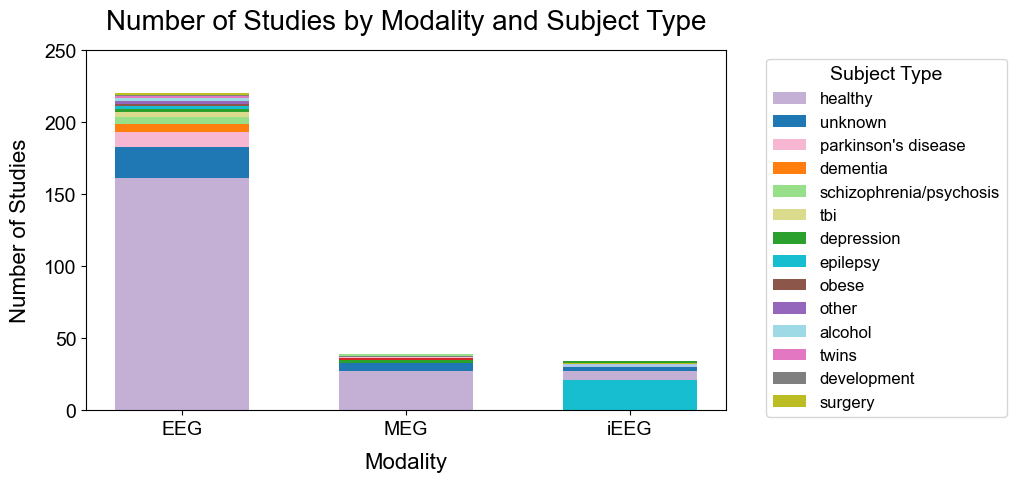

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

def plot_stacked_bars(
    data, 
    stack_orders, 
    group_order=None, 
    bar_width=0.6, 
    figsize=(8, 6), 
    title="Stacked Bar Chart",
    ax=None
):

    # Determine ordering of groups
    if group_order is None:
        group_order = list(stack_orders.keys())
    
    # Gather all categories
    all_categories = {cat for order in stack_orders.values() for cat in order}
    
    cmap = plt.cm.get_cmap('tab20', len(all_categories))
    # color_map = {cat: cmap(i) for i, cat in enumerate(np.random.permutation(sorted(all_categories)))}
    # color_map = {cat: cmap(i) for i, cat in enumerate(sorted(all_categories))}
    # Swap specific pairs of colors in the colormap
    swaps = [(0, 15), (9, 14), (4, 11), (6, 9)]
    colors = [cmap(i) for i in range(len(all_categories))]
    for a, b in swaps:
        colors[a], colors[b] = colors[b], colors[a]
    color_map = {cat: colors[i] for i, cat in enumerate(sorted(all_categories))}
    
    # Create figure/axis if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(group_order))
    
    # Draw each bar with its custom stack order
    for i, grp in enumerate(group_order):
        bottom = 0
        for cat in stack_orders[grp]:
            value = data.get(grp, {}).get(cat, 0)
            ax.bar(
                x[i], value, bar_width, bottom=bottom, 
                color=color_map[cat], 
                label=cat if i == 0 else ""
            )
            bottom += value
    ax.set_xticks(x)
    ax.set_xticklabels(group_order)
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend(title="Category")
    
    return ax

# Example usage
example_data = {
    'Group 1': {'Cat A': 3, 'Cat B': 2, 'Cat C': 1},
    'Group 2': {'Cat A': 1, 'Cat B': 2, 'Cat C': 4},
    'Group 3': {'Cat A': 2, 'Cat B': 1, 'Cat C': 3}
}
stack_orders = {
    'Group 1': ['Cat A', 'Cat B', 'Cat C'],
    'Group 2': ['Cat B', 'Cat C', 'Cat A'],
    'Group 3': ['Cat C', 'Cat A', 'Cat B']
}

df_eeg = df[df['EEG Modality'].notna() & (df['EEG Modality'] != '')]
df_meg = df[df['MEG Modality'].notna() & (df['MEG Modality'] != '')]
df_ieeg = df[df['iEEG Modality'].notna() & (df['iEEG Modality'] != '')]

modality_data = {
    'EEG': df_eeg['FOR FIG - Type Subject'].value_counts().to_dict(),
    'MEG': df_meg['FOR FIG - Type Subject'].value_counts().to_dict(),
    'iEEG': df_ieeg['FOR FIG - Type Subject'].value_counts().to_dict()
}

modality_stack_orders = {
    'EEG': sorted(modality_data['EEG'], key=modality_data['EEG'].get, reverse=True),
    'MEG': sorted(modality_data['MEG'], key=modality_data['MEG'].get, reverse=True),
    'iEEG': sorted(modality_data['iEEG'], key=modality_data['iEEG'].get, reverse=True)
}

cmap = plt.colormaps.get_cmap('tab20')  # Use 'tab20' for 20 distinct colors
print(cmap)

fig, ax = plt.subplots(figsize=(8, 6))
plot_stacked_bars(modality_data, modality_stack_orders, ax=ax)

# Add labels and title with padding
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Modality', fontsize=16, labelpad=10)  # Add padding to x label
plt.ylabel('Number of Studies', fontsize=16, labelpad=10)  # Add padding to y label
plt.legend(title='Subject Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.ylim(0, 250)
plt.title('Number of Studies by Modality and Subject Type', fontsize=20, loc='center', pad=15)  # Add padding to title
plt.gca().set_position([0.1, 0.2, 0.8, 0.6])  # Adjust the position of the graph to center it

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Save the plot as PNG and SVG
plt.savefig('results/v1.6/figure_8.png', format='png', bbox_inches='tight')
plt.savefig('results/v1.6/figure_8.svg', format='svg', bbox_inches='tight')


plt.show()

In [ ]:
# Extract the column and count occurrences of "healthy"
healthy_count = df['FOR FIG - Type Subject'].str.lower().value_counts().get('healthy', 0)
print(f"Number of entries labeled as 'healthy': {healthy_count}")
total_entries = df['FOR FIG - Type Subject'].notna().sum()
percentage_healthy = (healthy_count / total_entries) * 100
print(f"Percentage of entries labeled as 'healthy': {percentage_healthy:.2f}%")

Number of entries labeled as 'healthy': 193
Percentage of entries labeled as 'healthy': 66.32%


In [ ]:
201/269

0.7472118959107806

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df_fig2 = df[['EEG Modality', 
              'MEG Modality', 
              'iEEG Modality',
              'Has MRI',
              'Has EOG',
              'Has Behavioral',
              'Has fMRi',
              'Has EcOg',
              'Has DBS',
              'Has SMI',
              'Has EMG',
              'Has TMS',
              'Has ECG',
              'Has SEEG',
              'Has fNIRS',
              'Has Blood Tests',
              'Eye tracking'
              ]]

df_fig2.rename(columns={
    'EEG Modality': 'EEG',
    'MEG Modality': 'MEG',
    'iEEG Modality': 'iEEG',
    'Has MRI': 'MRI',
    'Has EOG': 'EOG',
    'Has Behavioral': 'Behavioral',
    'Has fMRi': 'fMRI',
    'Has EcOg': 'EcOg',
    'Has DBS': 'DBS',
    'Has SMI': 'SMI',
    'Has EMG': 'EMG',
    'Has TMS': 'TMS',
    'Has ECG': 'ECG',
    'Has SEEG': 'SEEG',
    'Has fNIRS': 'fNIRS',
    'Has Blood Tests': 'Blood Tests',
    'Eye tracking': 'Eye Tracking'
}, inplace=True)

df_fig2_primaryModalities = ['EEG', 'MEG', 'iEEG']
df_fig2_additionalModalities = ['MRI', 
                                'EOG', 
                                'Behavioral', 
                                'fMRI', 
                                'EcOg', 
                                'DBS', 
                                'SMI', 
                                'EMG', 
                                'TMS', 
                                'ECG', 
                                'SEEG', 
                                'fNIRS', 
                                'Blood Tests', 
                                'Eye Tracking', 
                                ]

fig, axes = plt.subplots(1, 3, figsize=(36, 12))  # Create a figure with 3 subplots

# Function to create and draw a graph with adjusted figure size and layout
def create_and_draw_graph_subplot(start_node, additional_modalities, df, title, ax):
    G = nx.DiGraph()
    G.add_node(start_node)
    for modality in additional_modalities:
        G.add_node(modality)
        weight = df[(df[start_node] == 'x') & (df[modality] == 'x')].shape[0]
        if weight > 0:
            G.add_edge(start_node, modality, weight=weight)
    
    pos = nx.circular_layout(G)
    pos[start_node] = [0, 0]  # Place the start node in the center
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]

    for i, weight in enumerate(weights):
        weights[i] = np.log1p(weight) * 4

    legend_weights = [2.772588722239781, 9.591581091193483, 12.178089750893692, 13.735948817940585, 14.854288266817232]
    print(weights)
   
    nx.draw(G, 
            pos, 
            with_labels=True, 
            node_size=14000, 
            node_color='skyblue', 
            font_size=30, 
            font_weight='bold', 
            edge_color=weights, 
            edge_cmap=plt.cm.Blues, 
            width=[weight for weight in weights],  # Use weights for line thickness
            ax=ax)
    ax.set_title(title, fontsize=30)  # Increase the font size of the title
    ax.margins(0.1)  # Adjust the margins to ensure everything fits

    # Add a legend for edge thickness
    legend_elements = [
        Line2D([0], [0], color=plt.cm.Blues(legend_weights[0] / max(legend_weights)), lw=legend_weights[0], label='Weight = 1'),
        Line2D([0], [0], color=plt.cm.Blues(legend_weights[1] / max(legend_weights)), lw=legend_weights[1], label='Weight = 10'),
        Line2D([0], [0], color=plt.cm.Blues(legend_weights[2] / max(legend_weights)), lw=legend_weights[2], label='Weight = 20'),
        Line2D([0], [0], color=plt.cm.Blues(legend_weights[3] / max(legend_weights)), lw=legend_weights[3], label='Weight = 30'),
        Line2D([0], [0], color=plt.cm.Blues(legend_weights[4] / max(legend_weights)), lw=legend_weights[4], label='Weight = 40'),
    ]

    ax.legend(handles=legend_elements, loc='upper left', fontsize=20, bbox_to_anchor=(1, 1))

# Draw the EEG graph
create_and_draw_graph_subplot('EEG', df_fig2_additionalModalities, df_fig2, '', axes[0])
# Draw the MEG graph
create_and_draw_graph_subplot('MEG', df_fig2_additionalModalities, df_fig2, '', axes[1])
# Draw the iEEG graph
create_and_draw_graph_subplot('iEEG', df_fig2_additionalModalities, df_fig2, '', axes[2])

plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.savefig('results/v1.6/figure_3.svg', format='svg')
plt.savefig('results/v1.6/figure_3.png', format='png')

plt.show()
